<a href="https://colab.research.google.com/github/AhnJG/AI-Project/blob/master/Colab/Korea_COVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import and Data Load

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline 


# 아래는 matplot 한글 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [ ]:
import io
import requests
url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
csv_data=requests.get(url).content
confirmed_df=pd.read_csv(io.StringIO(csv_data.decode('utf-8')))

In [ ]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/KoreaCOVIDTimeProvince.csv")
data

,date,time,province,confirmed,released,deceased
0,2020-01-20,16,Seoul,0,0,0
1,2020-01-20,16,Busan,0,0,0
2,2020-01-20,16,Daegu,0,0,0
3,2020-01-20,16,Incheon,1,0,0
4,2020-01-20,16,Gwangju,0,0,0
...,...,...,...,...,...,...
1202,2020-03-30,0,Jeollabuk-do,13,7,0
1203,2020-03-30,0,Jeollanam-do,9,3,0
1204,2020-03-30,0,Gyeongsangbuk-do,1298,772,38
1205,2020-03-30,0,Gyeongsangnam-do,95,65,0


## PreProcessing

In [ ]:
# 시간 컬럼 삭제 후 인덱스를 시간으로 변경
del_data = data.drop(columns=['time'])
del_data.set_index('date', inplace=True)

# 도시 목록
provinces = list(set(del_data.province.tolist()))
provinces

# 도시 각각의 프레임을 배열로 저장
province_data = []
for province in provinces:
    province_data.append(del_data[del_data.province == province])

# 도시, 완치, 사망 컬럼 삭제 후 province 컬럼의 이름을 실제 도시 이름으로 변경
for i in range(len(provinces)):
    province_data[i].drop(columns=['province', 'released', 'deceased'], inplace=True)
    province_data[i].columns = [provinces[i]]
    
province_data

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[            Gyeongsangbuk-do
 date                        
 2020-01-20                 0
 2020-01-21                 0
 2020-01-22                 0
 2020-01-23                 0
 2020-01-24                 0
 ...                      ...
 2020-03-26              1274
 2020-03-27              1283
 2020-03-28              1285
 2020-03-29              1287
 2020-03-30              1298
 
 [71 rows x 1 columns],             Seoul
 date             
 2020-01-20      0
 2020-01-21      0
 2020-01-22      0
 2020-01-23      0
 2020-01-24      0
 ...           ...
 2020-03-26    360
 2020-03-27    372
 2020-03-28    390
 2020-03-29    410
 2020-03-30    426
 
 [71 rows x 1 columns],             Gyeonggi-do
 date                   
 2020-01-20            0
 2020-01-21            0
 2020-01-22            0
 2020-01-23            0
 2020-01-24            1
 ...                 ...
 2020-03-26          401
 2020-03-27          412
 2020-03-28          433
 2020-03-29          448
 2020-03-30  

In [ ]:
# 도시별 데이터 프레임을 하나의 데이터 프레임으로 합친다
province_data = province_data[0].join(province_data[1:])
province_data

# 수도권 확진자 데이터
metropolitan_data = pd.DataFrame({'Seoul':province_data['Seoul'], 'Incheon':province_data['Incheon'], 'Gyeonggi-do':province_data['Gyeonggi-do']})
metropolitan_data

,Seoul,Incheon,Gyeonggi-do
date,,,
2020-01-20,0,1,0
2020-01-21,0,1,0
2020-01-22,0,1,0
2020-01-23,0,1,0
2020-01-24,0,1,1
...,...,...,...
2020-03-26,360,43,401
2020-03-27,372,46,412
2020-03-28,390,51,433


In [ ]:
# 수도권의 확진자 합계
metropolitan_data = metropolitan_data.sum(axis=1)
metropolitan_data = pd.DataFrame({'metropolitan':metropolitan_data})
metropolitan_data

,metropolitan
date,
2020-01-20,1
2020-01-21,1
2020-01-22,1
2020-01-23,1
2020-01-24,2
...,...
2020-03-26,804
2020-03-27,830
2020-03-28,874


In [ ]:
confirmed_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20
0,NaN,Afghanistan,33.00000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,Falkland Islands (Malvinas),United Kingdom,-51.79630,-59.523600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2
259,Saint Pierre and Miquelon,France,46.88520,-56.315900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
260,NaN,South Sudan,6.87700,31.307000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2
261,NaN,Western Sahara,24.21550,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4


In [ ]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17


In [ ]:
cols = confirmed_df.keys()
cols

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20',
       '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20',
       '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20', '4/7/20'],
      dtype='object')

In [ ]:
# 1/22/20 ~ 3/30/20
confirmed = confirmed_df.loc[:, cols[4]:cols[72]]
confirmed

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
259,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
260,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
261,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# # 나라목록에서 한국이름 찾기
# contains_korea = confirmed_df['Country/Region'].str.contains("Korea")

# # 조건를 충족하는 데이터를 필터링하여 새로운 변수에 저장합니다.
# subset_df = confirmed_df[contains_korea]
# subset_df

In [ ]:
dates = confirmed.keys()

world_cases = []
china_cases = [] 
italy_cases = []
us_cases = [] 
spain_cases = [] 
france_cases = [] 
korea_cases = []

for i in dates:
    confirmed_sum = confirmed[i].sum()
    world_cases.append(confirmed_sum)

    # case studies 
    china_cases.append(confirmed_df[confirmed_df['Country/Region']=='China'][i].sum())
    italy_cases.append(confirmed_df[confirmed_df['Country/Region']=='Italy'][i].sum())
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    spain_cases.append(confirmed_df[confirmed_df['Country/Region']=='Spain'][i].sum())
    france_cases.append(confirmed_df[confirmed_df['Country/Region']=='France'][i].sum())
    korea_cases.append(confirmed_df[confirmed_df['Country/Region']=='Korea, South'][i].sum())

In [ ]:
# 1/20 부터 시작하는 데이터 1/22로 변경
metropolitan_data = metropolitan_data[2:]

In [ ]:
# 수도권 확진자 데이터 리스트 형식, daily_increase 함수에 넣기위해 다른 cases 변수와 형태를 같이함
metropolitan_cases = list(metropolitan_data['metropolitan'])

In [ ]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

world_daily_increase = daily_increase(world_cases)
china_daily_increase = daily_increase(china_cases)
italy_daily_increase = daily_increase(italy_cases)
us_daily_increase = daily_increase(us_cases)
spain_daily_increase = daily_increase(spain_cases)
france_daily_increase = daily_increase(france_cases)
korea_daily_increase = daily_increase(korea_cases)
metropolitan_daily_increase = daily_increase(metropolitan_cases)

In [ ]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)

In [ ]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [ ]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))
    # 01/22/2020 ...

date_tick = []
for i in range(0, 69, 10):
    date_tick.append(future_forcast_dates[i])
date_tick.append(future_forcast_dates[68])
date_tick

['01/22/2020',
 '02/01/2020',
 '02/11/2020',
 '02/21/2020',
 '03/02/2020',
 '03/12/2020',
 '03/22/2020',
 '03/30/2020']

## ML Prediction

In [ ]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.10, shuffle=False) 

In [ ]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=7, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 41201.71190202383
MSE: 2044759384.882347


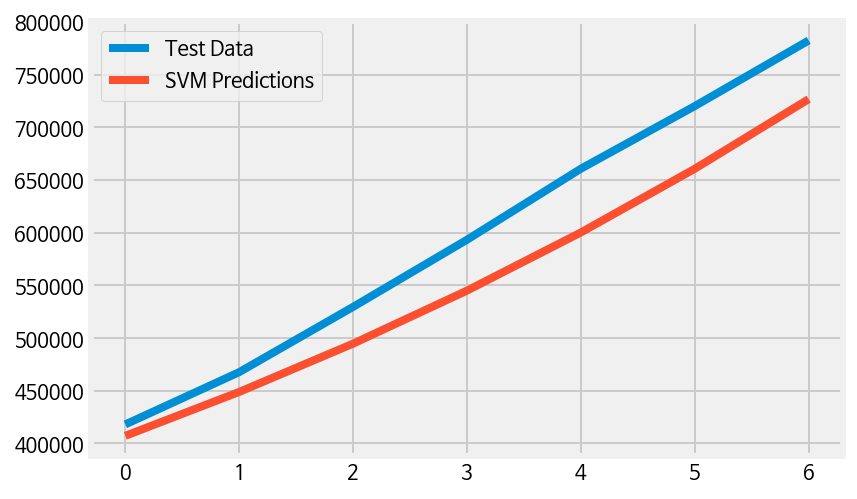

In [ ]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [ ]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

In [ ]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 10088.65690901478
MSE: 154726730.23676175


In [ ]:
print(linear_model.coef_)

[[ 1.03870773e+03 -6.44924141e+02  2.05828368e+02  3.66292126e-01
  -2.09138750e-01  2.91231952e-03]]


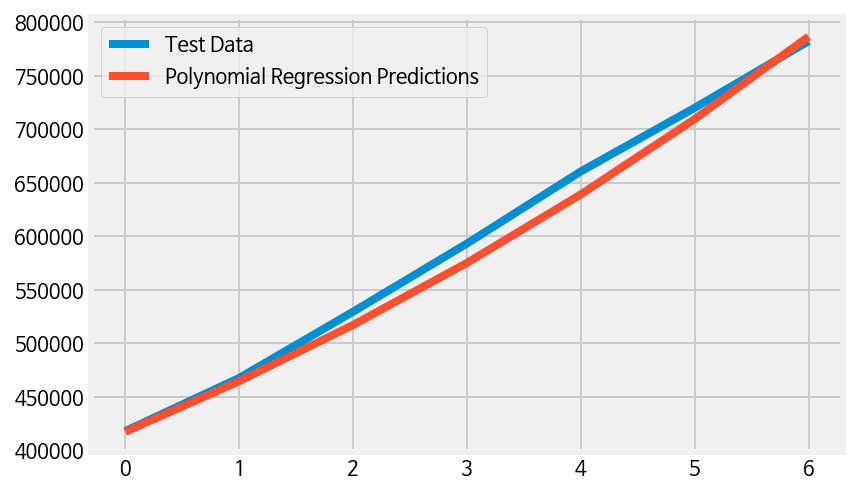

In [ ]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

In [ ]:
# bayesian ridge polynomial regression
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=True, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                 

In [ ]:
bayesian_search.best_params_

{'alpha_1': 1e-06,
 'alpha_2': 1e-06,
 'lambda_1': 0.0001,
 'lambda_2': 0.0001,
 'tol': 0.0001}

In [ ]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 8164.701715424125
MSE: 102817723.03499068


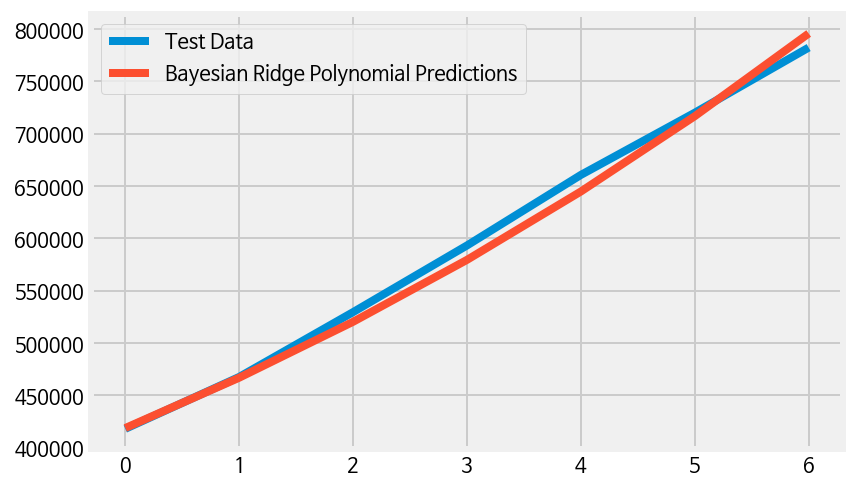

In [ ]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

## COVID Plotting

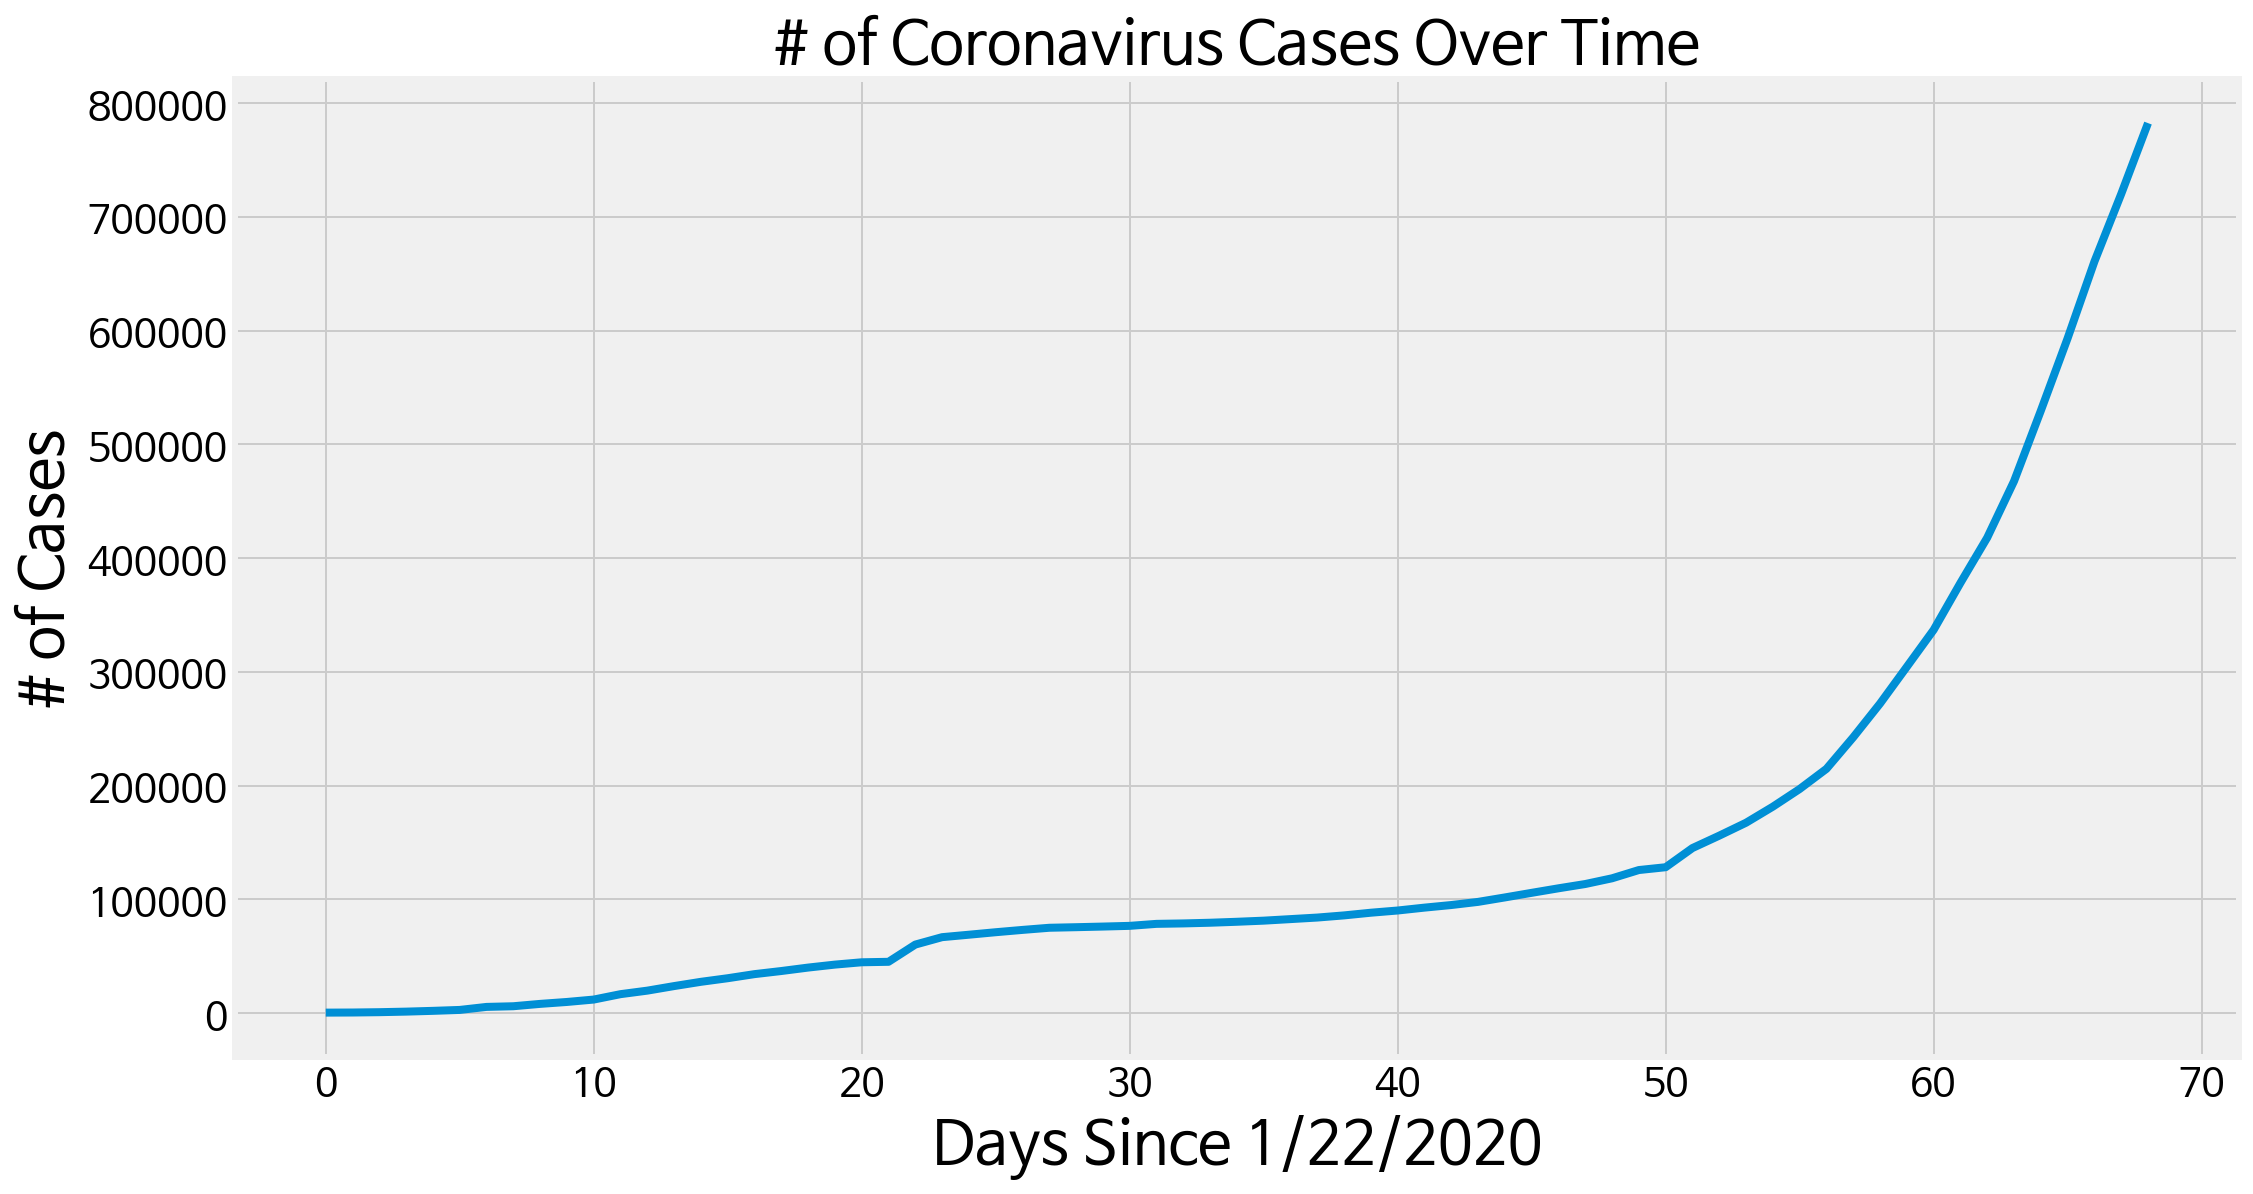

In [ ]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

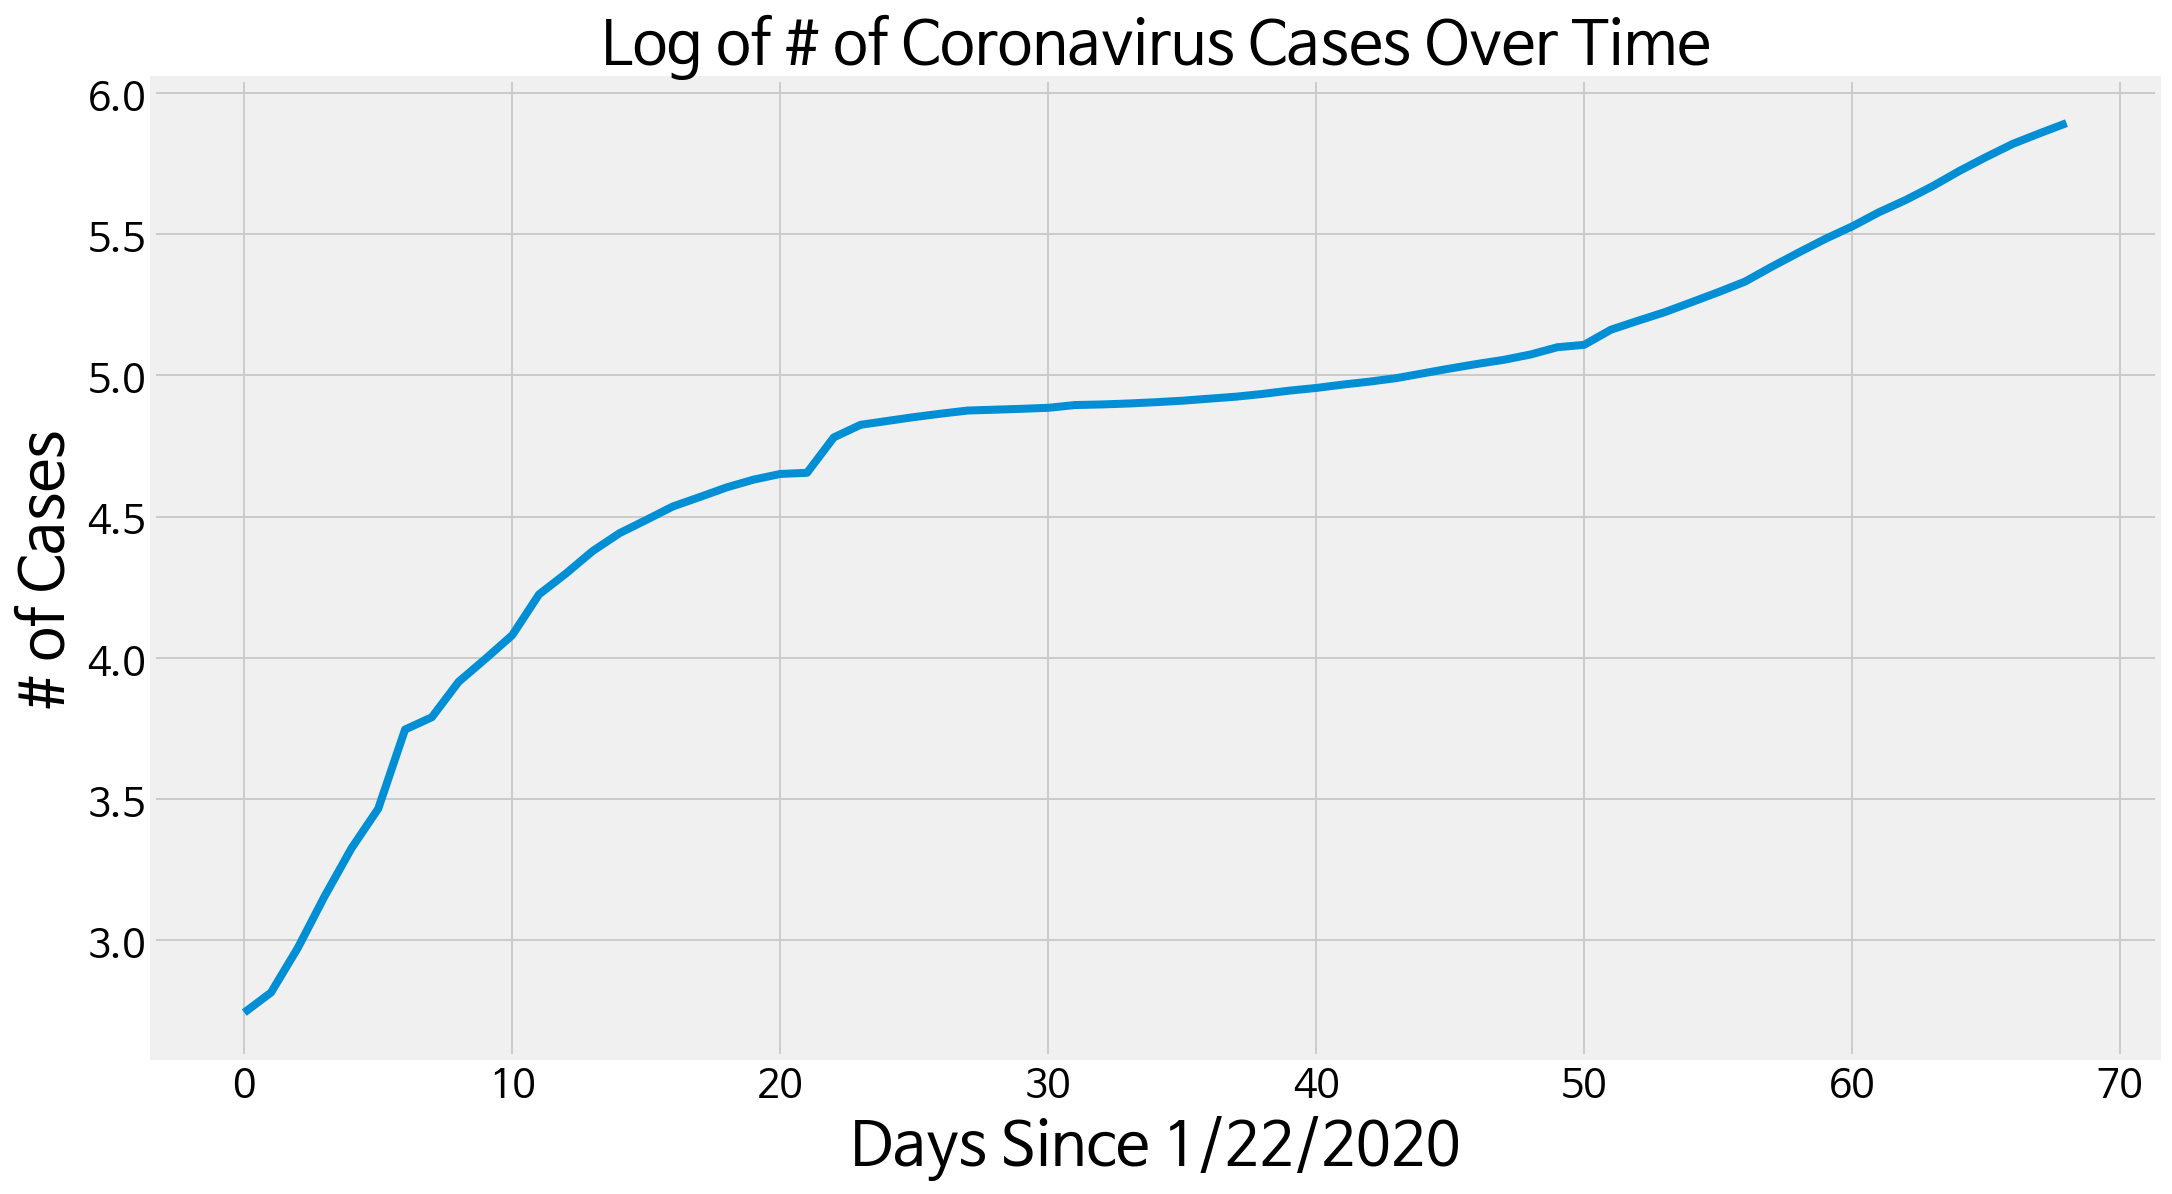

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, np.log10(world_cases))
plt.title('Log of # of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

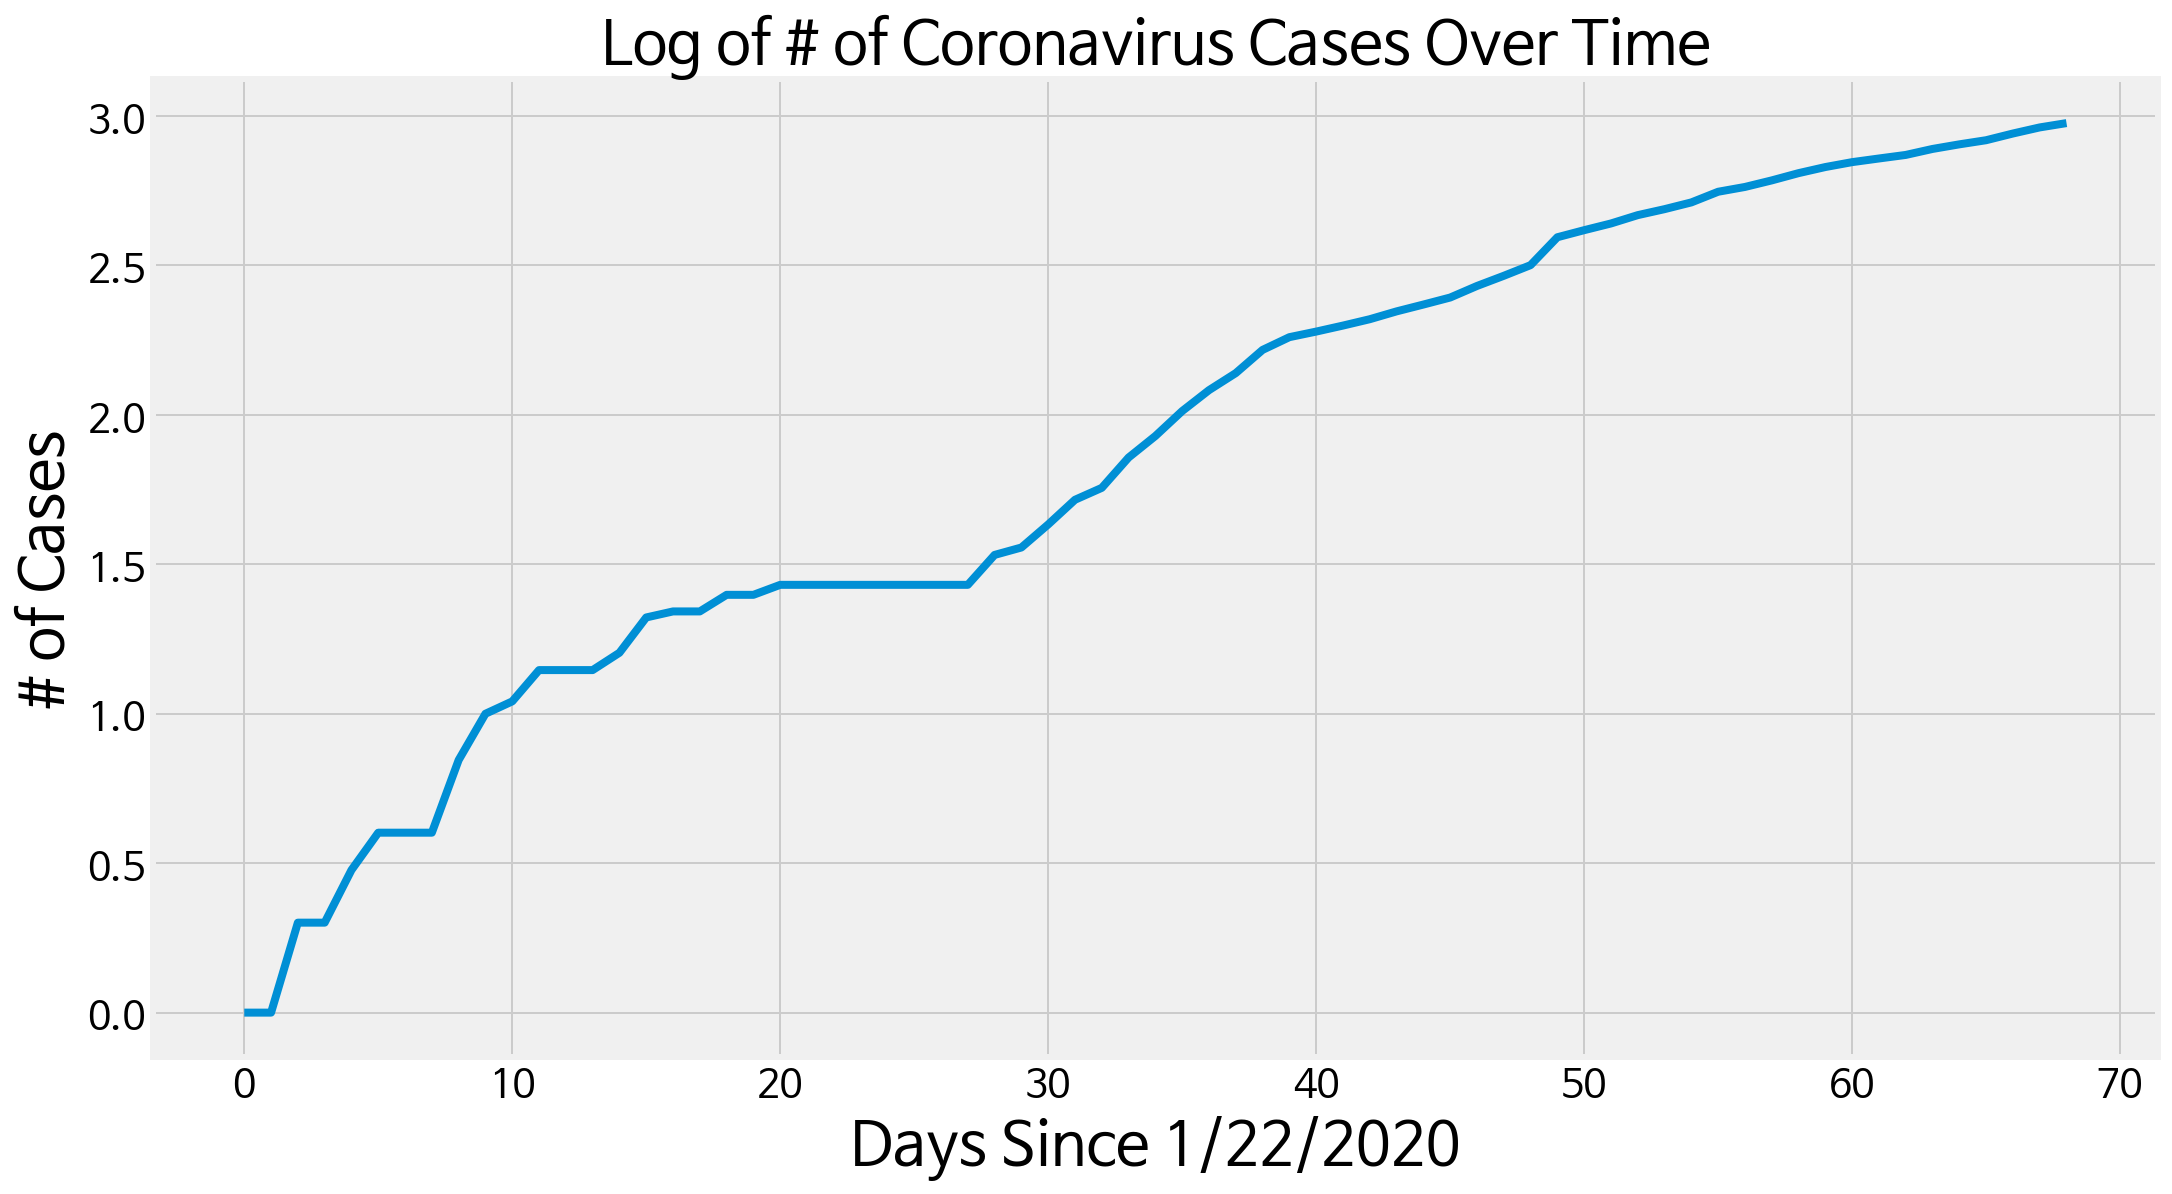

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, np.log10(metropolitan_cases))
plt.title('Log of # of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
# tmp_exp = 1e-4

# for i in range(len(korea_daily_increase)):
#     korea_daily_increase[i] = float(korea_daily_increase[i]) + tmp_exp
korea_daily_increase

[1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 7,
 1,
 3,
 0,
 1,
 3,
 4,
 1,
 0,
 1,
 2,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 73,
 100,
 229,
 169,
 231,
 144,
 284,
 505,
 571,
 813,
 586,
 599,
 851,
 435,
 467,
 505,
 448,
 273,
 164,
 35,
 242,
 114,
 110,
 107,
 76,
 74,
 84,
 93,
 152,
 87,
 147,
 162,
 0,
 76,
 100,
 104,
 91,
 146,
 105,
 78]

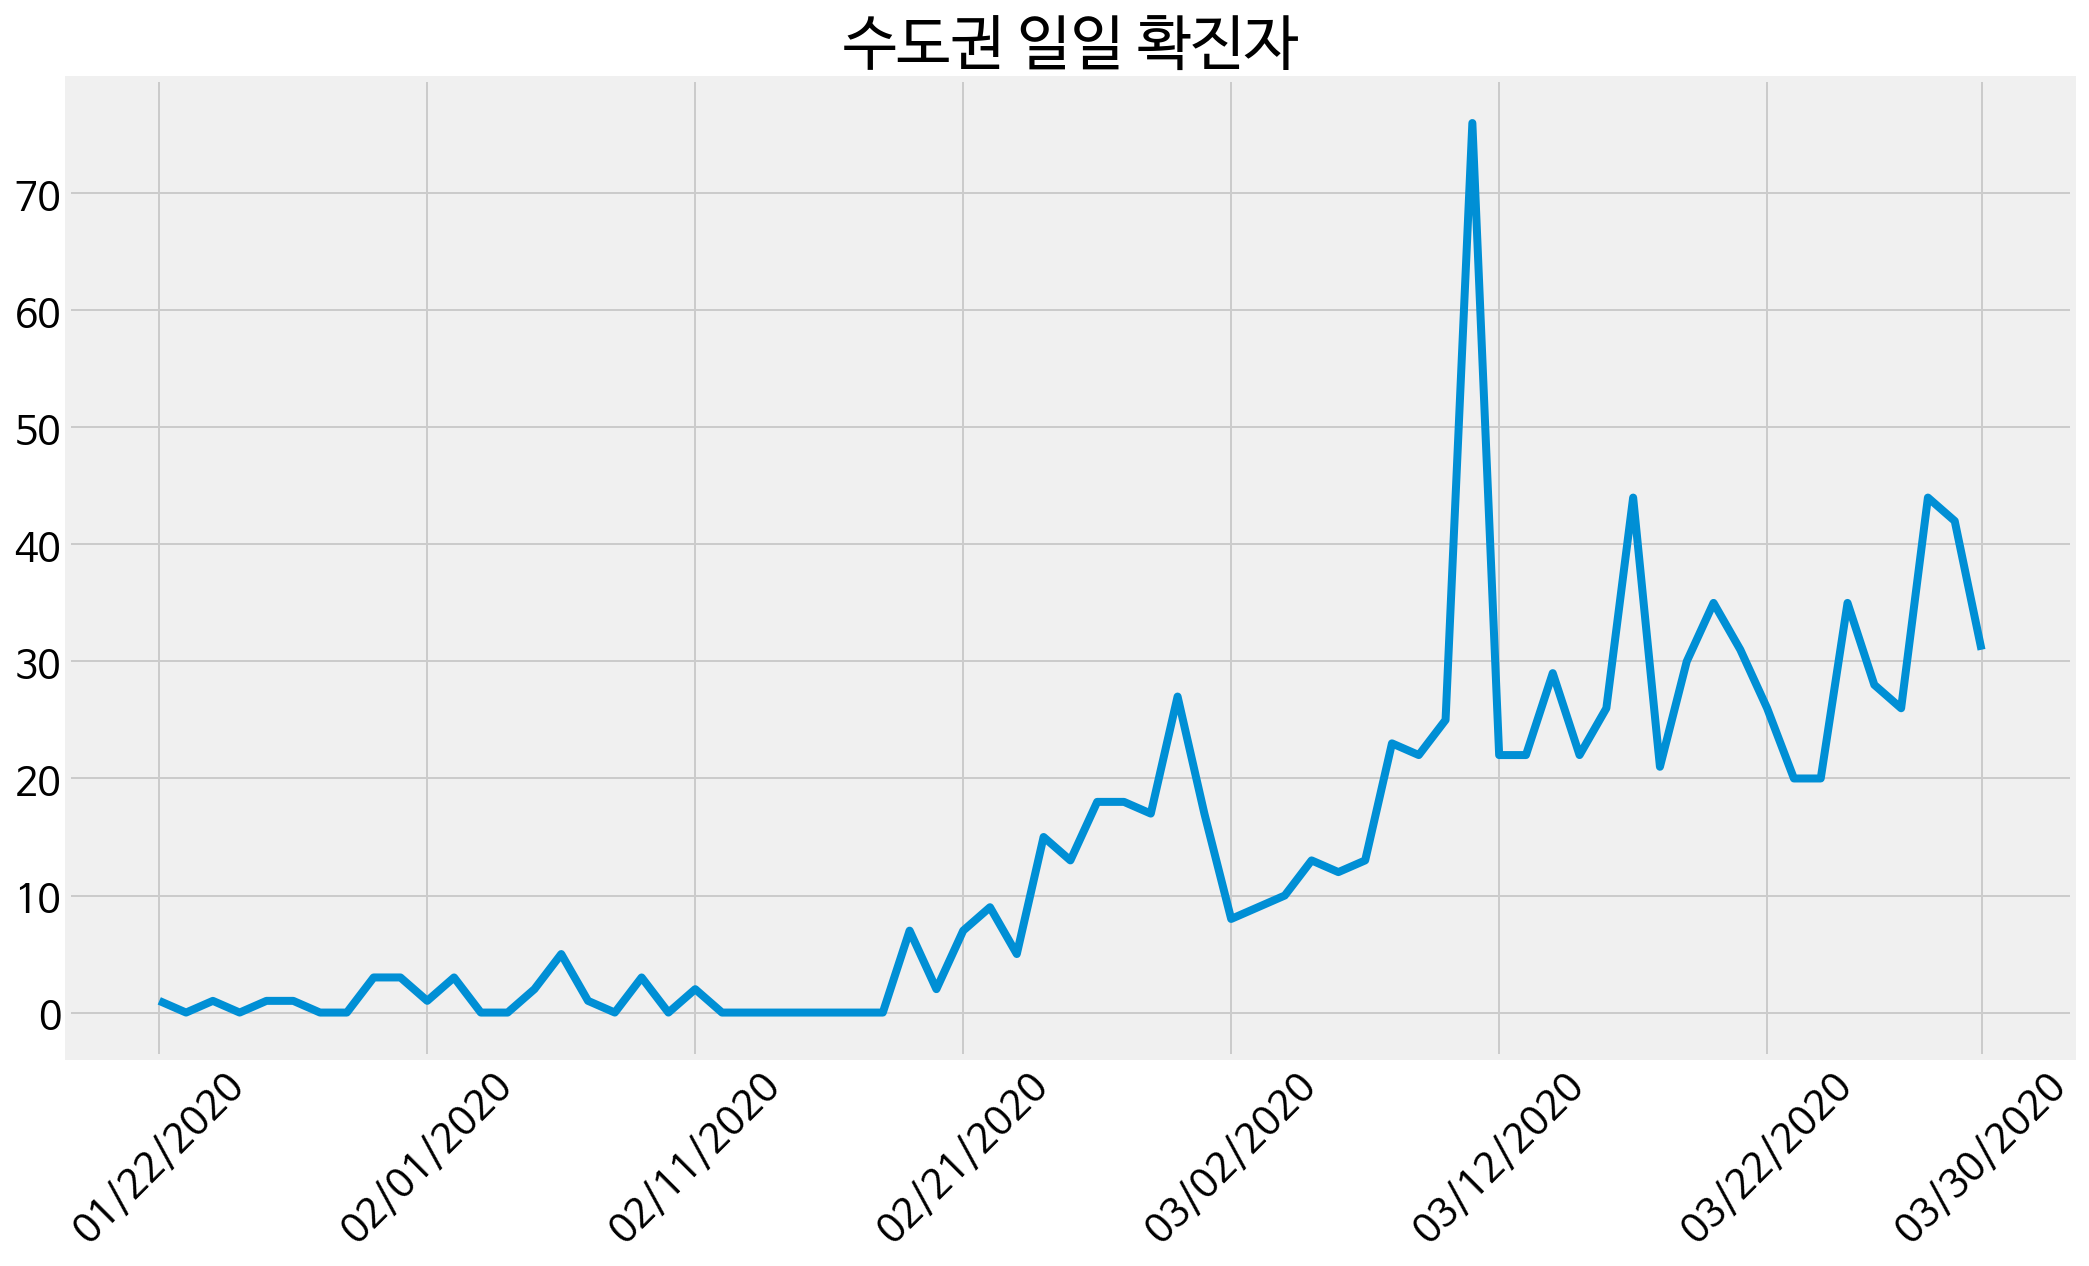

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(future_forcast_dates[:69], metropolitan_daily_increase)
plt.title('수도권 일일 확진자', size=30)
# plt.xlabel('Days Since 1/22/2020', size=30)
# plt.ylabel('# of Cases', size=30)
plt.xticks(date_tick, size=20, rotation=45)
plt.yticks(size=20)
plt.show()

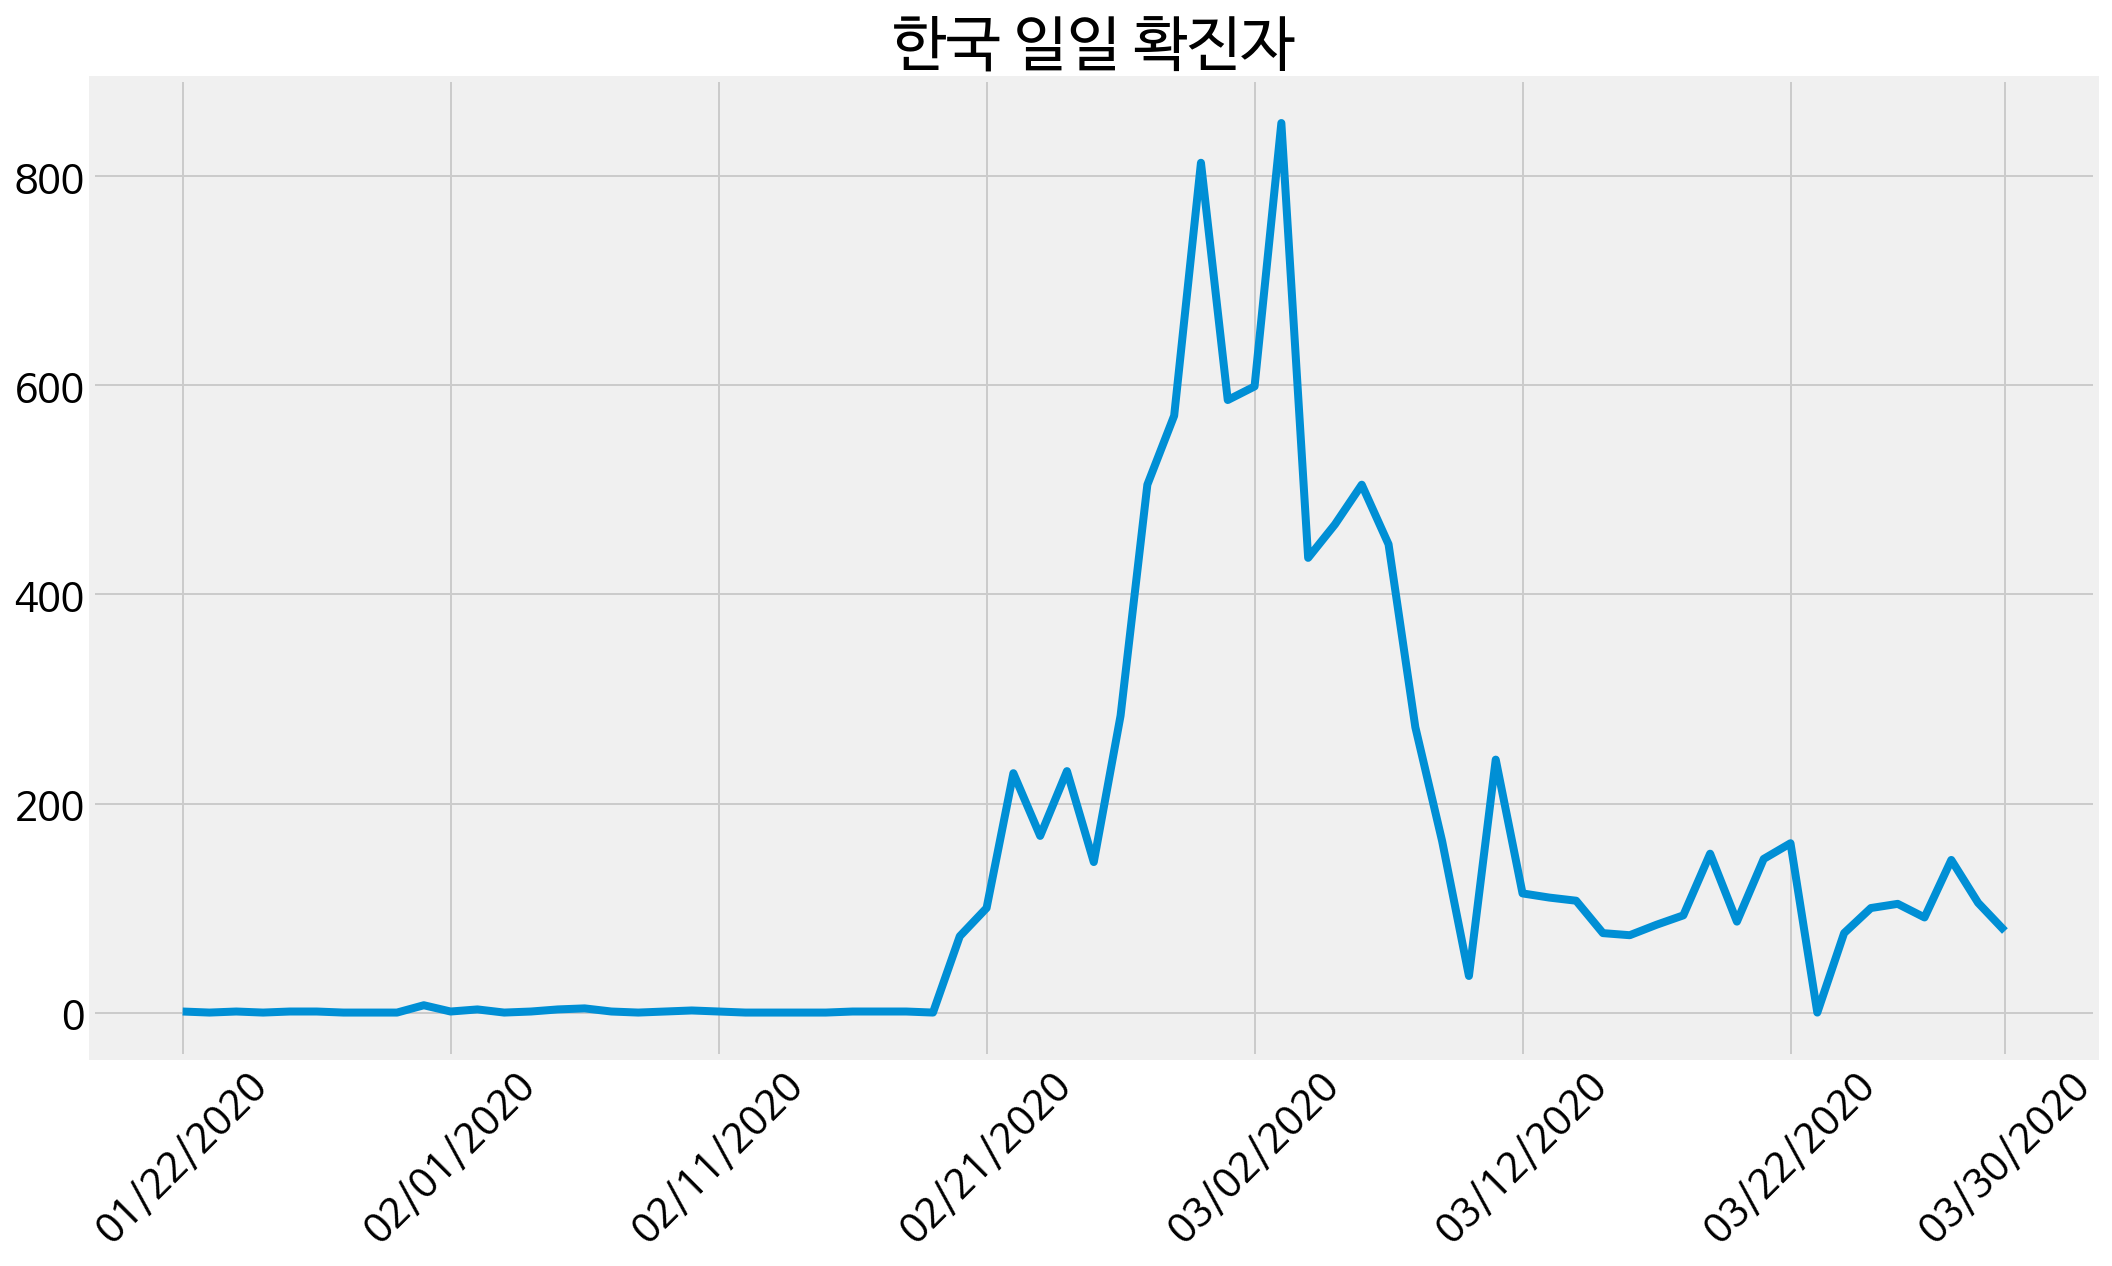

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(future_forcast_dates[:69], korea_daily_increase)
plt.title('한국 일일 확진자', size=30)
# plt.xlabel('Days Since 1/22/2020', size=30)
# plt.ylabel('# of Cases', size=30)
plt.xticks(date_tick, size=20, rotation=45)
plt.yticks(size=20)
plt.show()

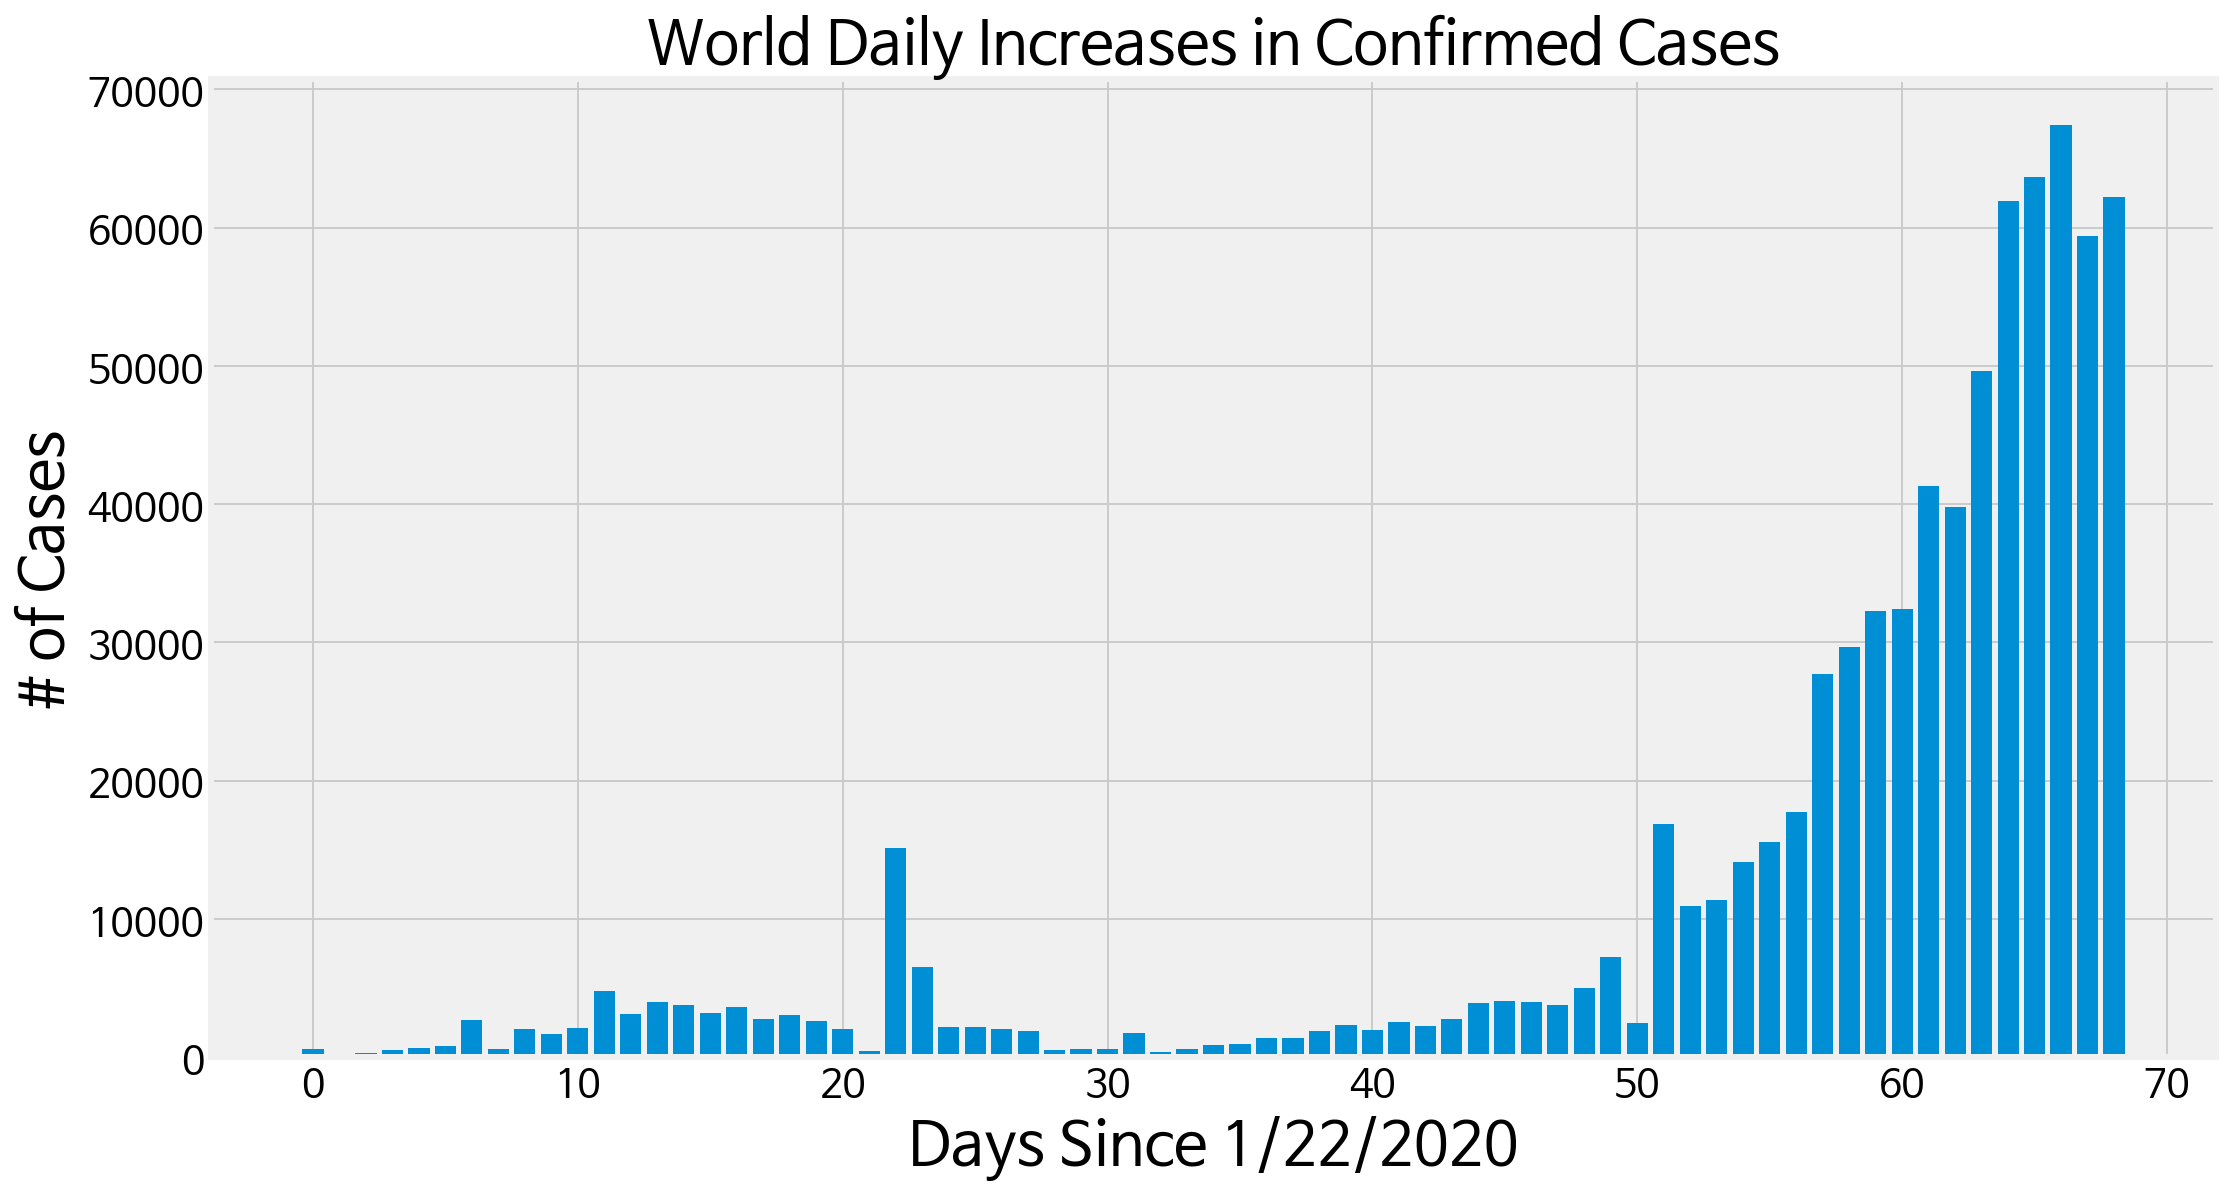

In [ ]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_increase)
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

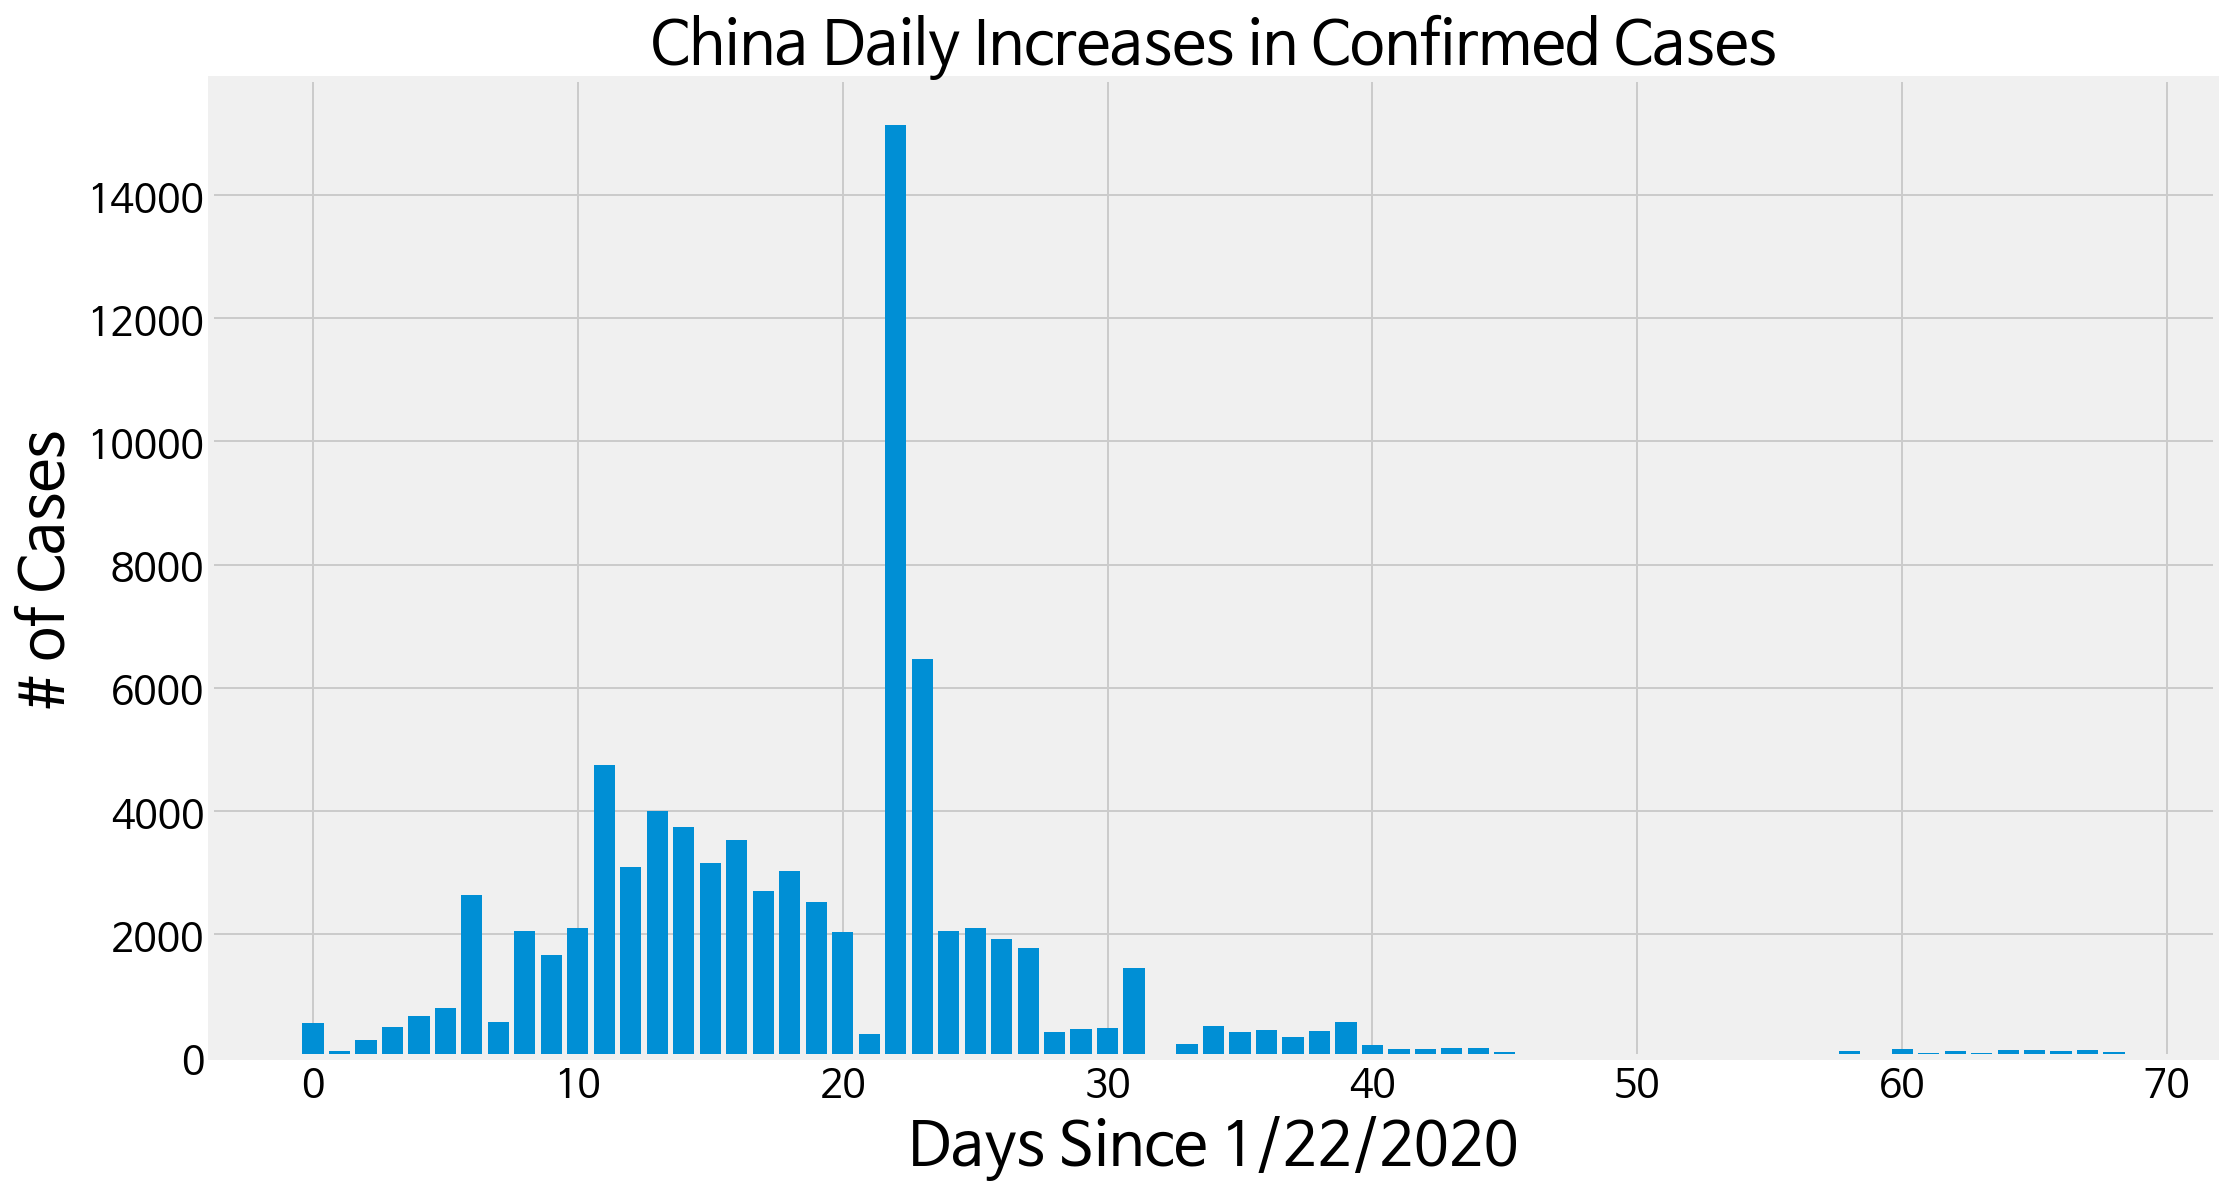

In [ ]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, china_daily_increase)
plt.title('China Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

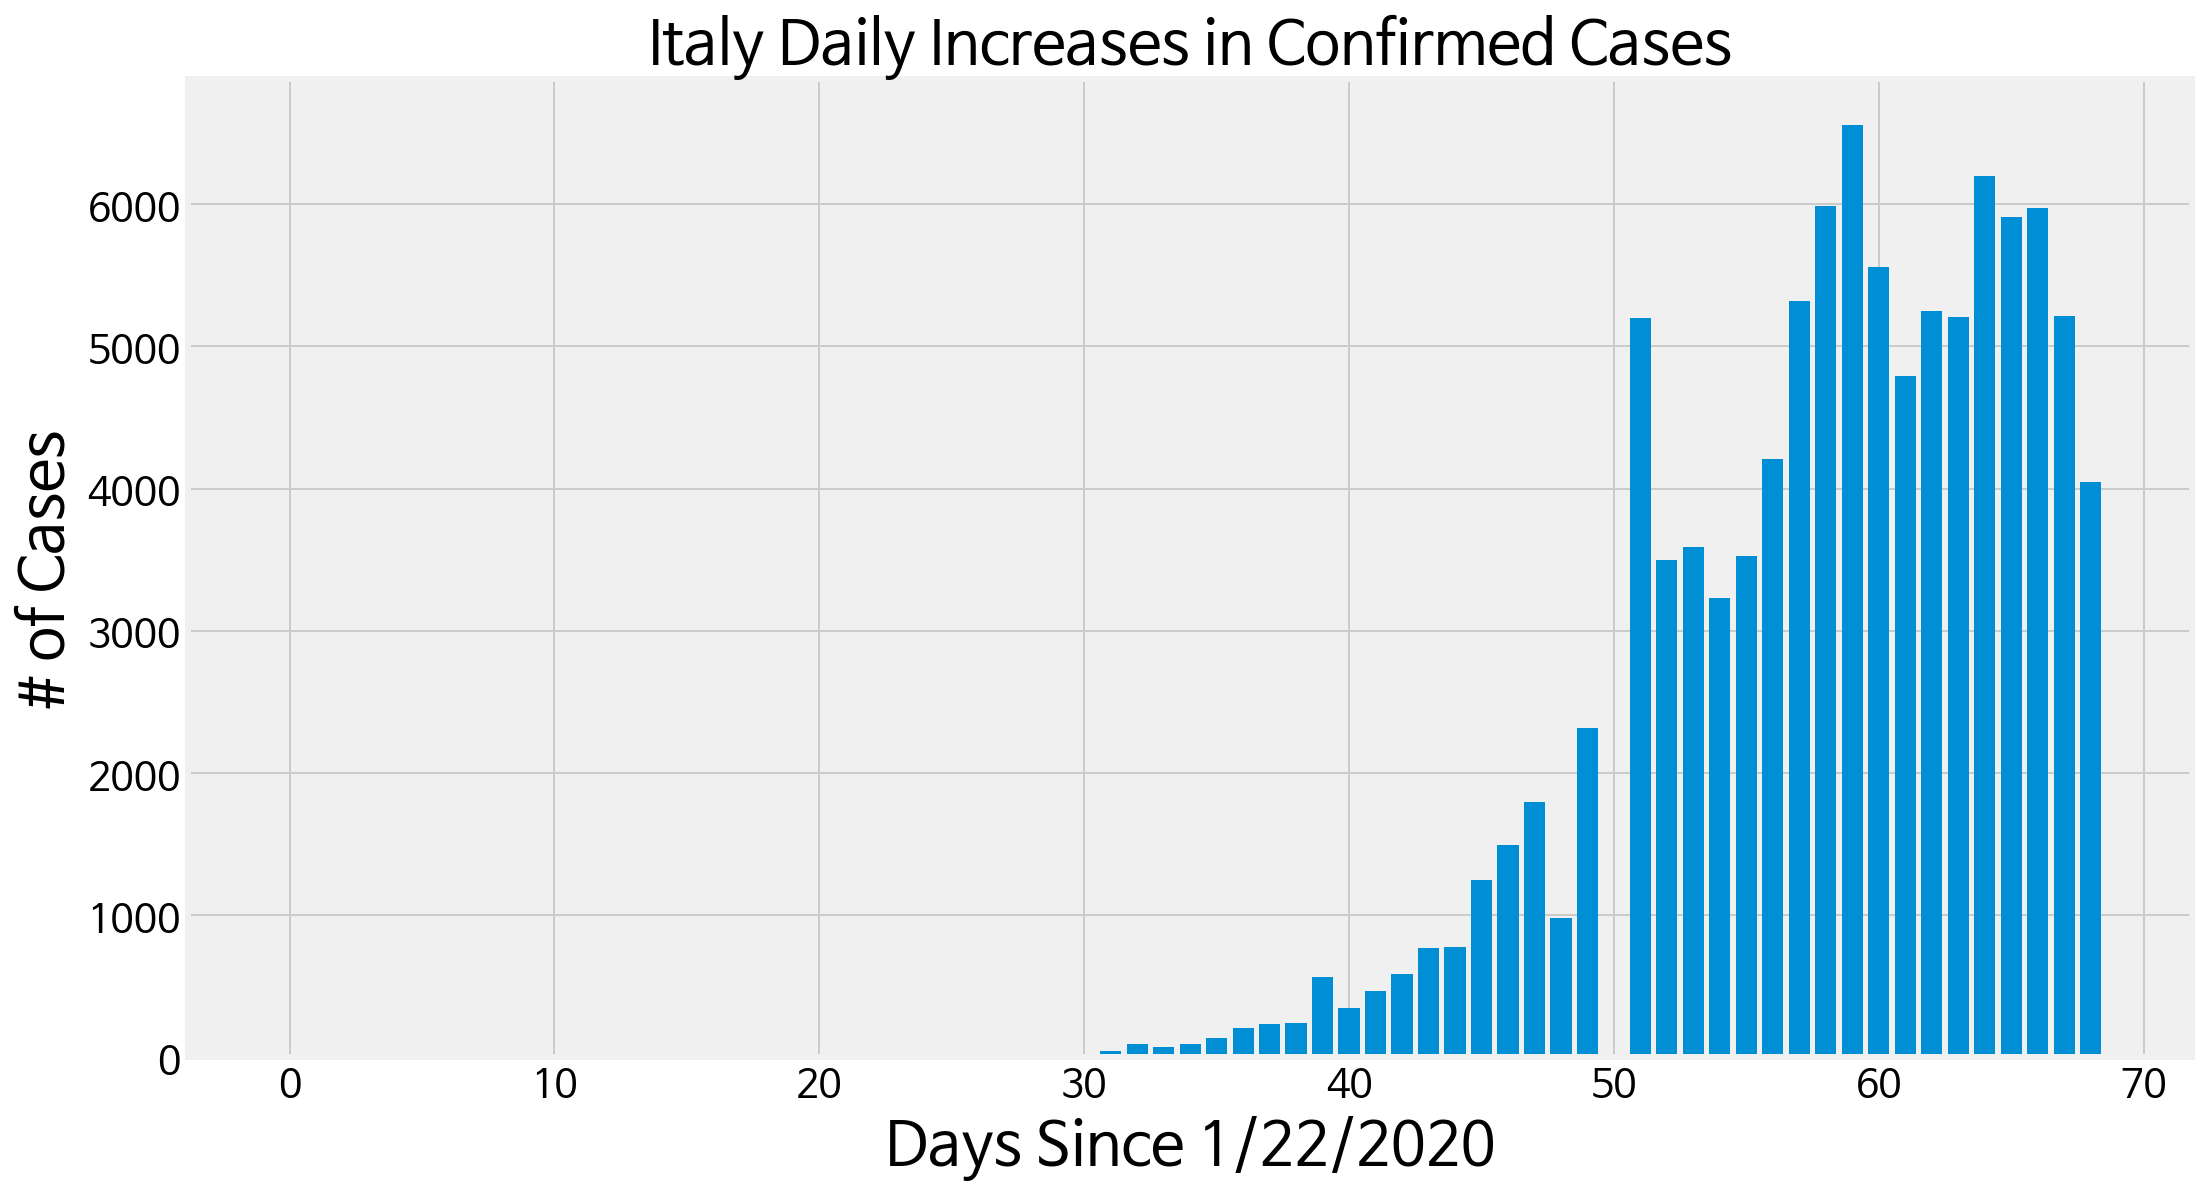

In [ ]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, italy_daily_increase)
plt.title('Italy Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

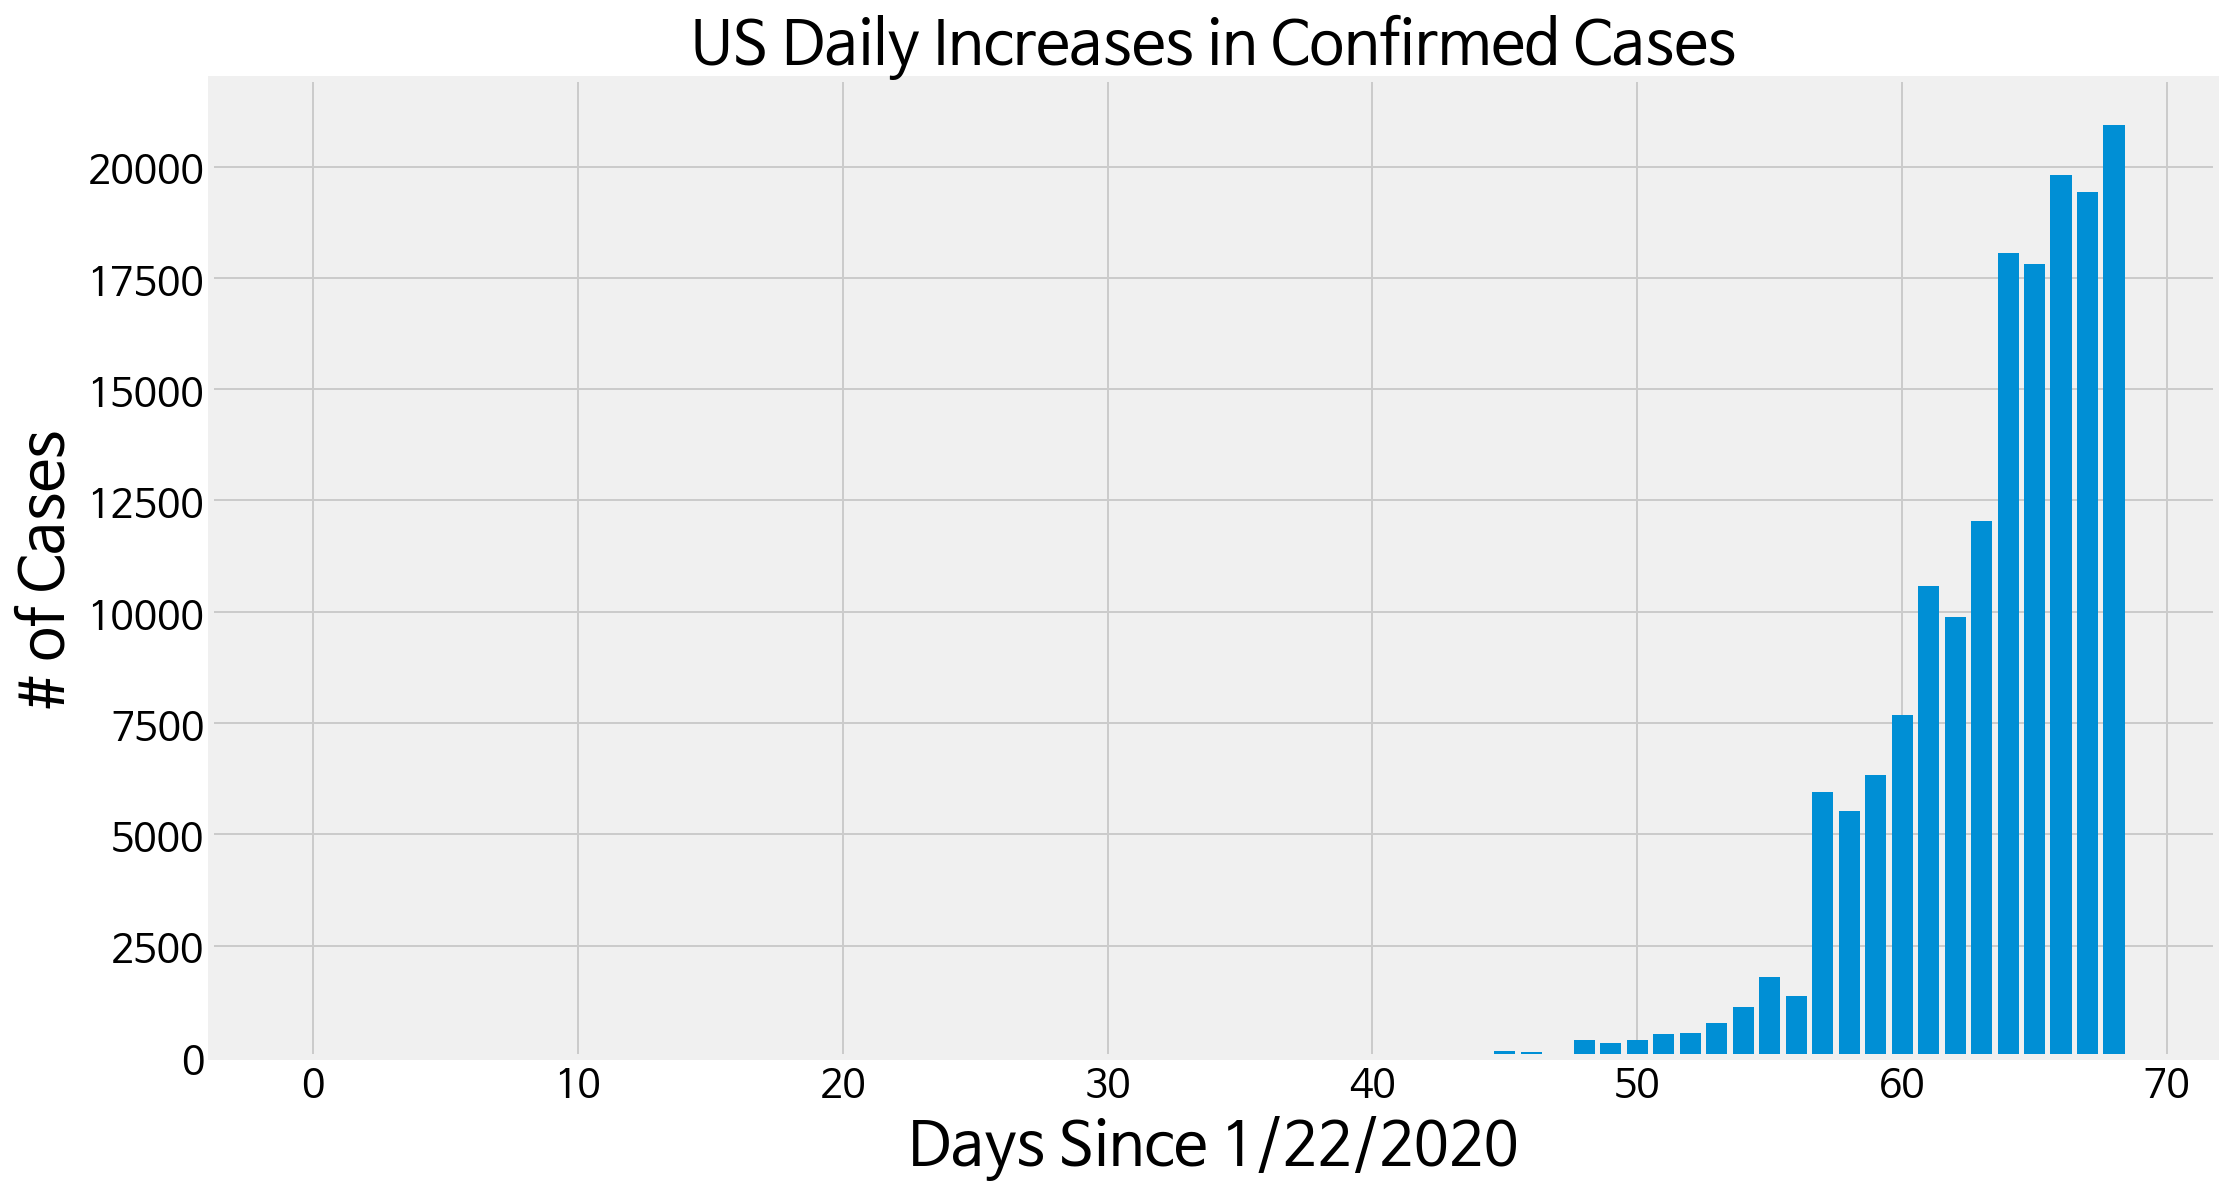

In [ ]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, us_daily_increase)
plt.title('US Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

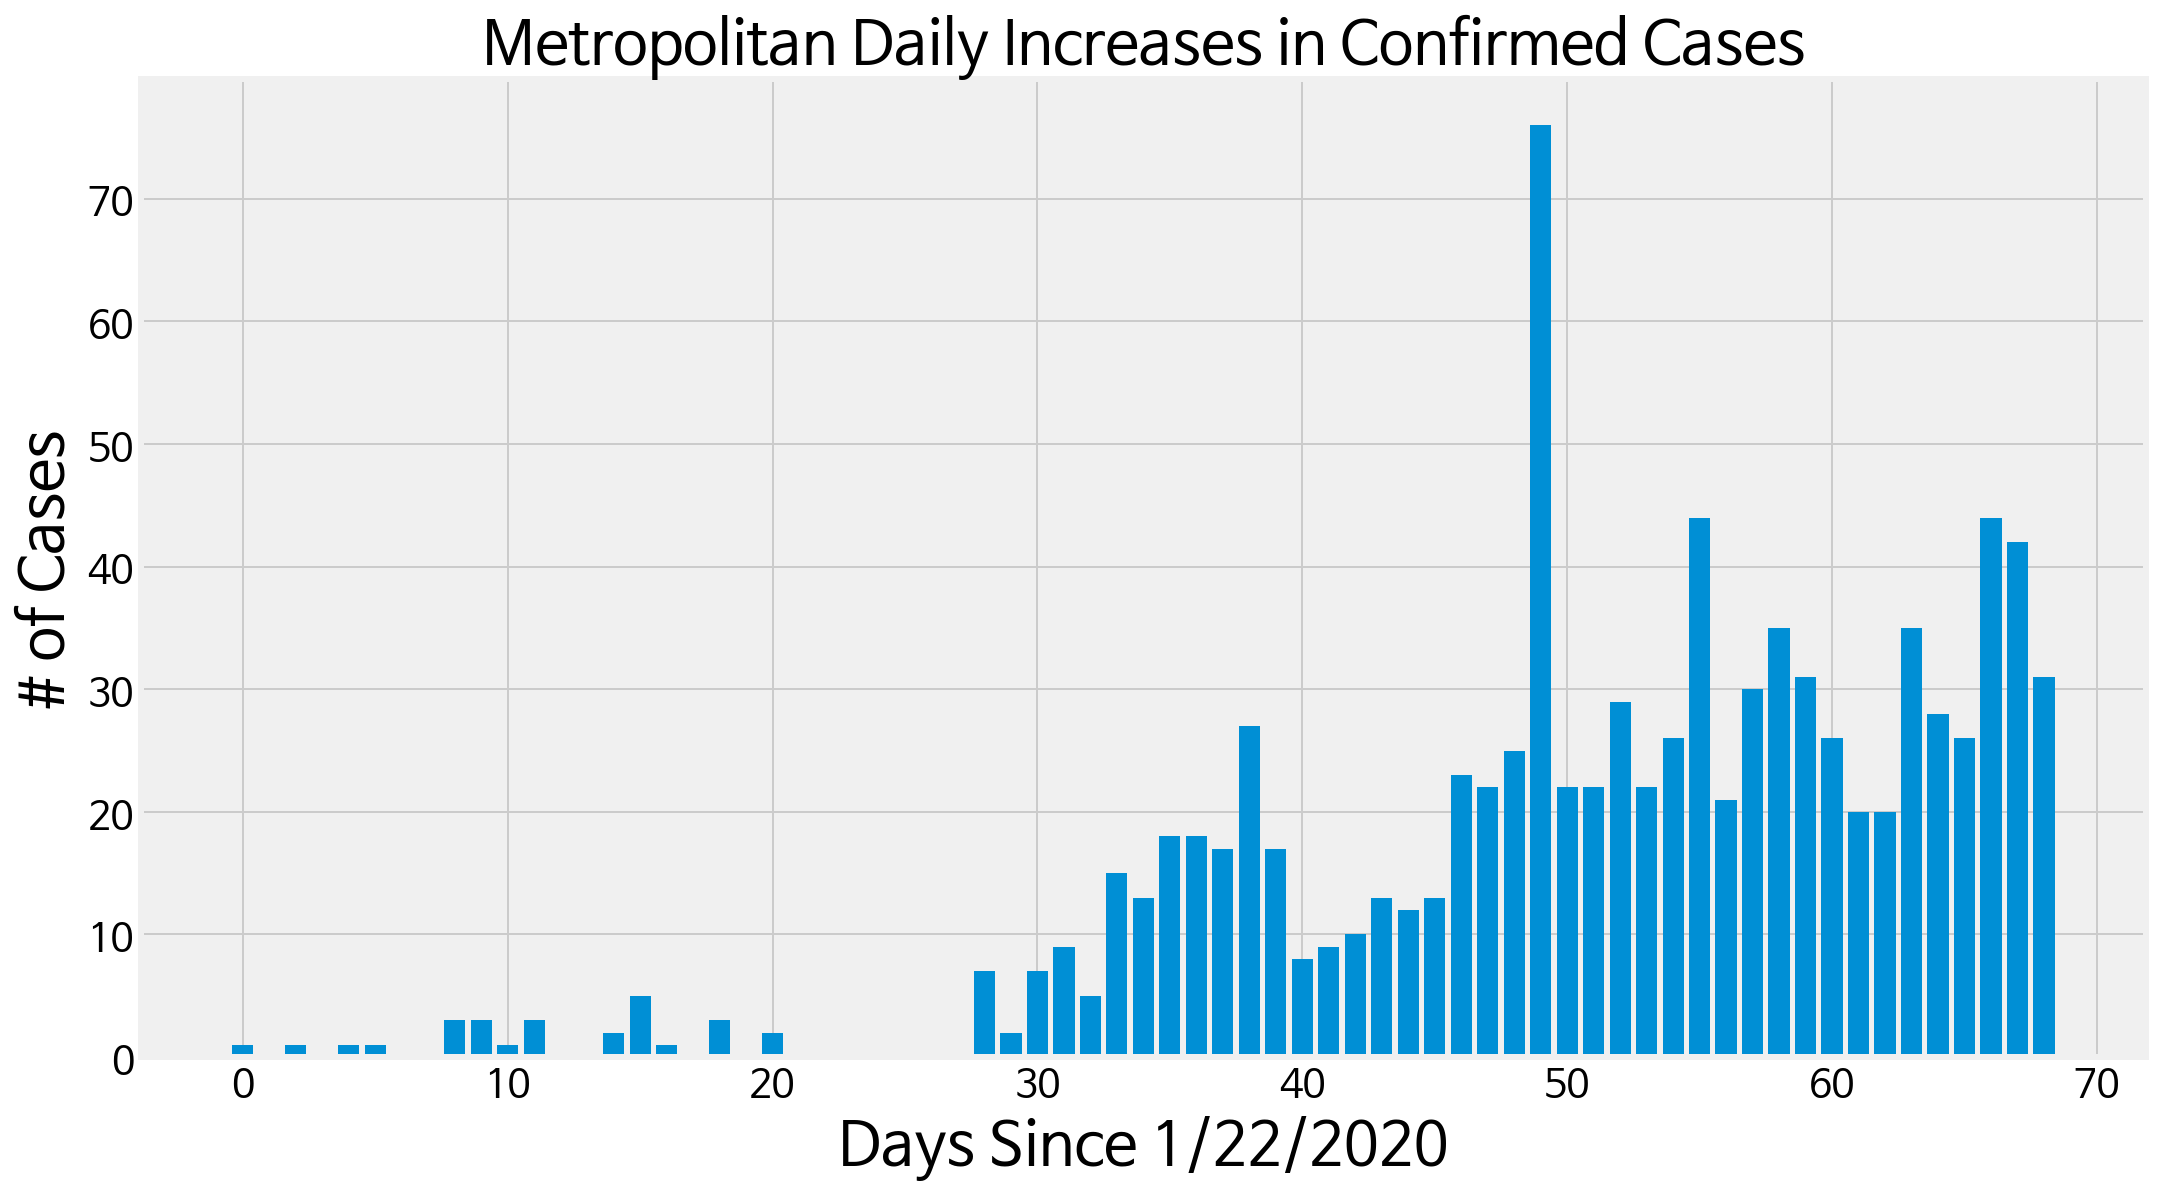

In [ ]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, metropolitan_daily_increase)
plt.title('Metropolitan Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
print(future_forcast_dates[0])
print(future_forcast_dates[68])

01/22/2020
03/30/2020


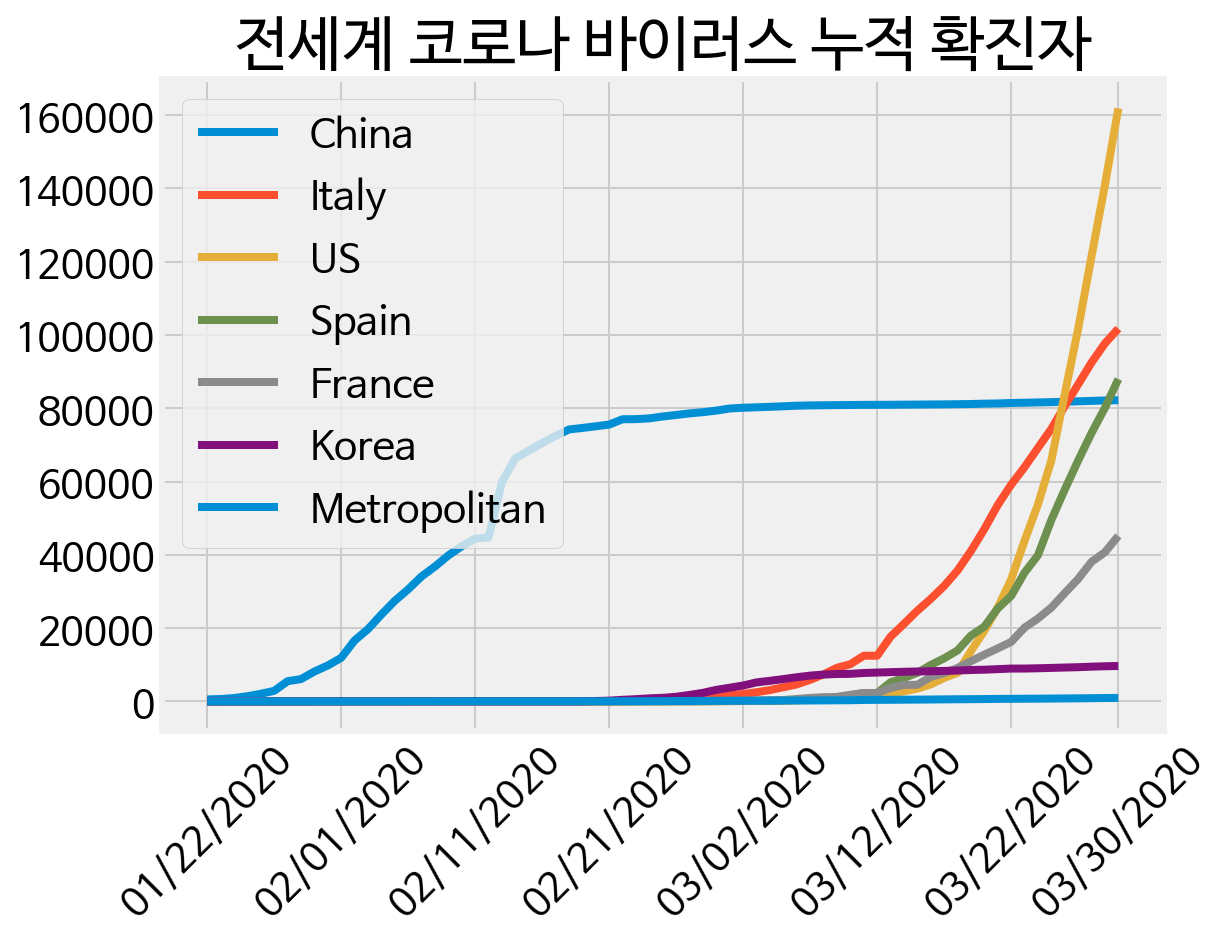

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(future_forcast_dates[:69], china_cases[:69])
plt.plot(future_forcast_dates[:69], italy_cases[:69])
plt.plot(future_forcast_dates[:69], us_cases[:69])
plt.plot(future_forcast_dates[:69], spain_cases[:69])
plt.plot(future_forcast_dates[:69], france_cases[:69])
plt.plot(future_forcast_dates[:69], korea_cases[:69])
plt.plot(future_forcast_dates[:69], metropolitan_cases[:69])
plt.title('전세계 코로나 바이러스 누적 확진자', size=30)
# plt.xlabel('1/22 ~ 3/30', size=30)
# plt.ylabel('확진자', size=30)
plt.legend(['China', 'Italy', 'US', 'Spain', 'France', 'Korea', 'Metropolitan'], prop={'size': 20})
plt.xticks(date_tick, size=20, rotation=45)
plt.yticks(size=20)
plt.show()

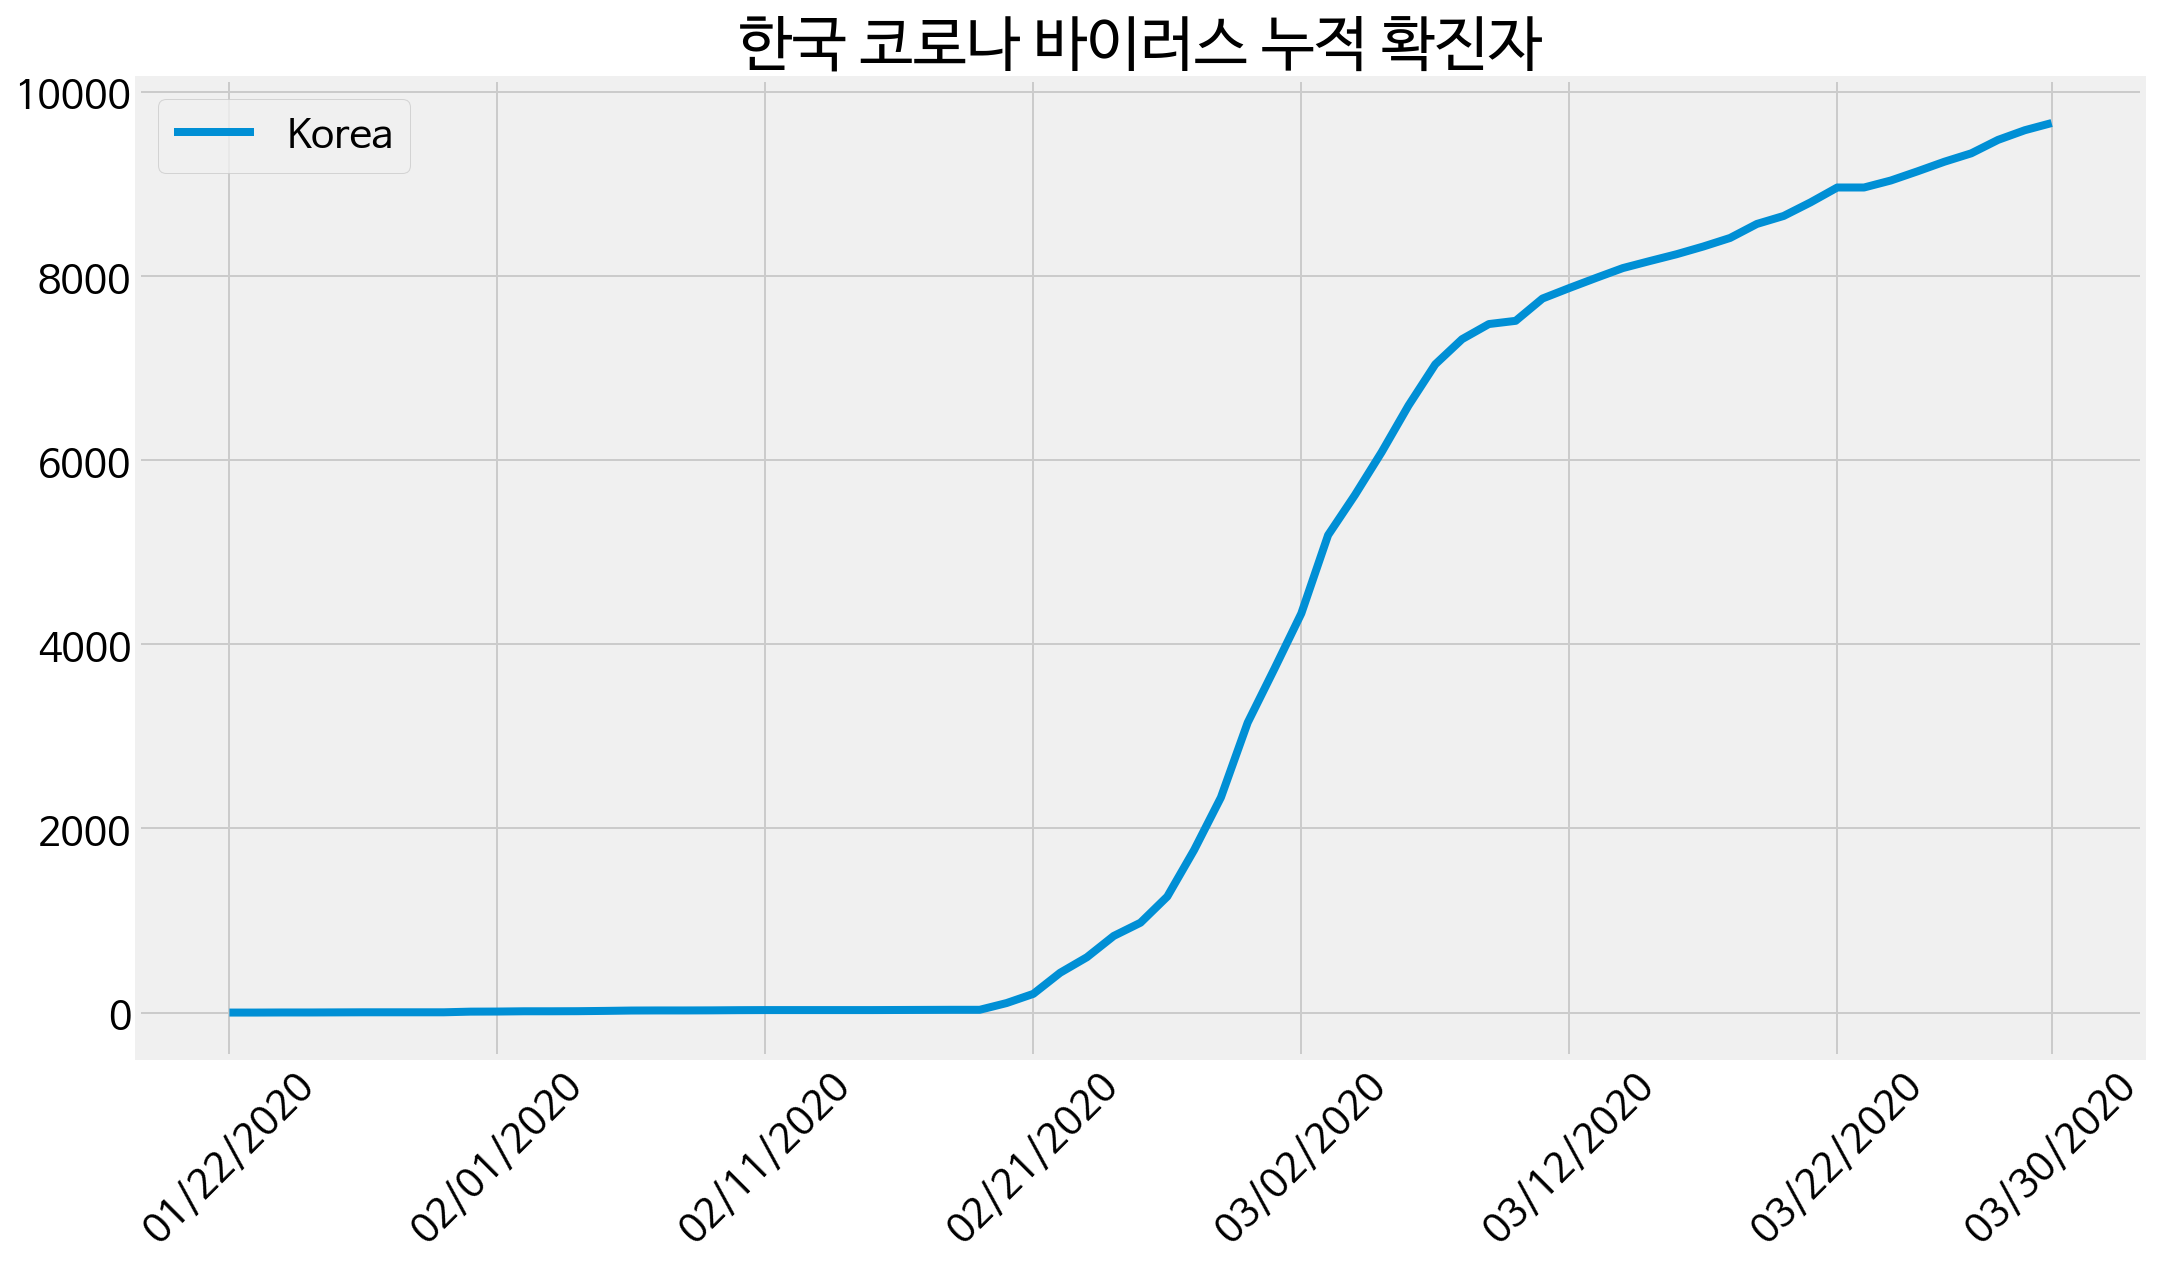

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(future_forcast_dates[:69], korea_cases[:69])
plt.title('한국 코로나 바이러스 누적 확진자', size=30)
# plt.xlabel('1/22 ~ 3/30', size=30)
# plt.ylabel('확진자', size=30)
plt.legend(['Korea'], prop={'size': 20})
plt.xticks(date_tick, size=20, rotation=45)
plt.yticks(size=20)
plt.show()

### ML Predict plot

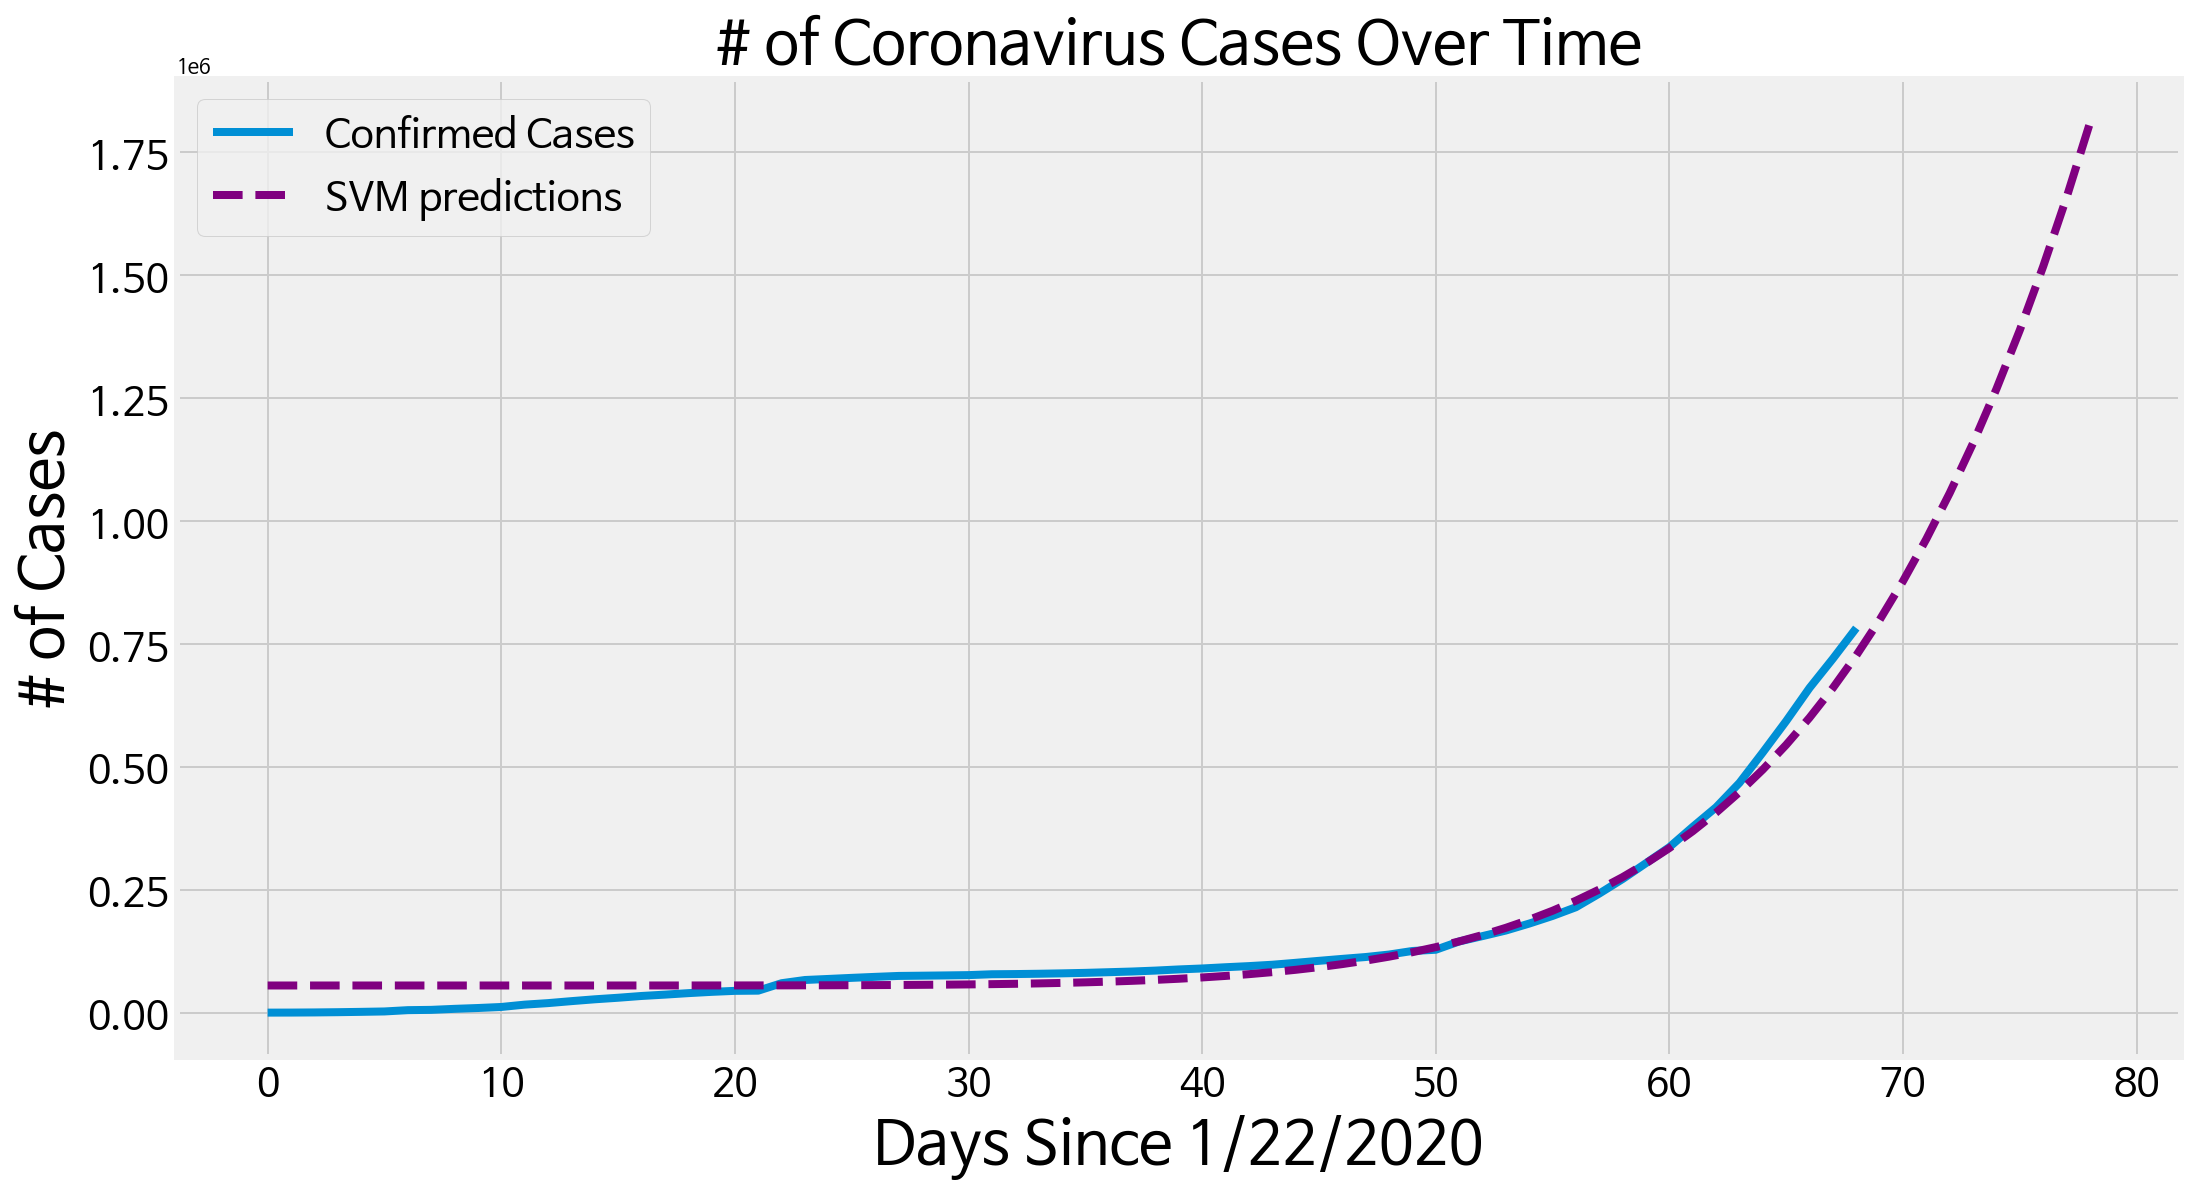

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, svm_pred, linestyle='dashed', color='purple')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'SVM predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

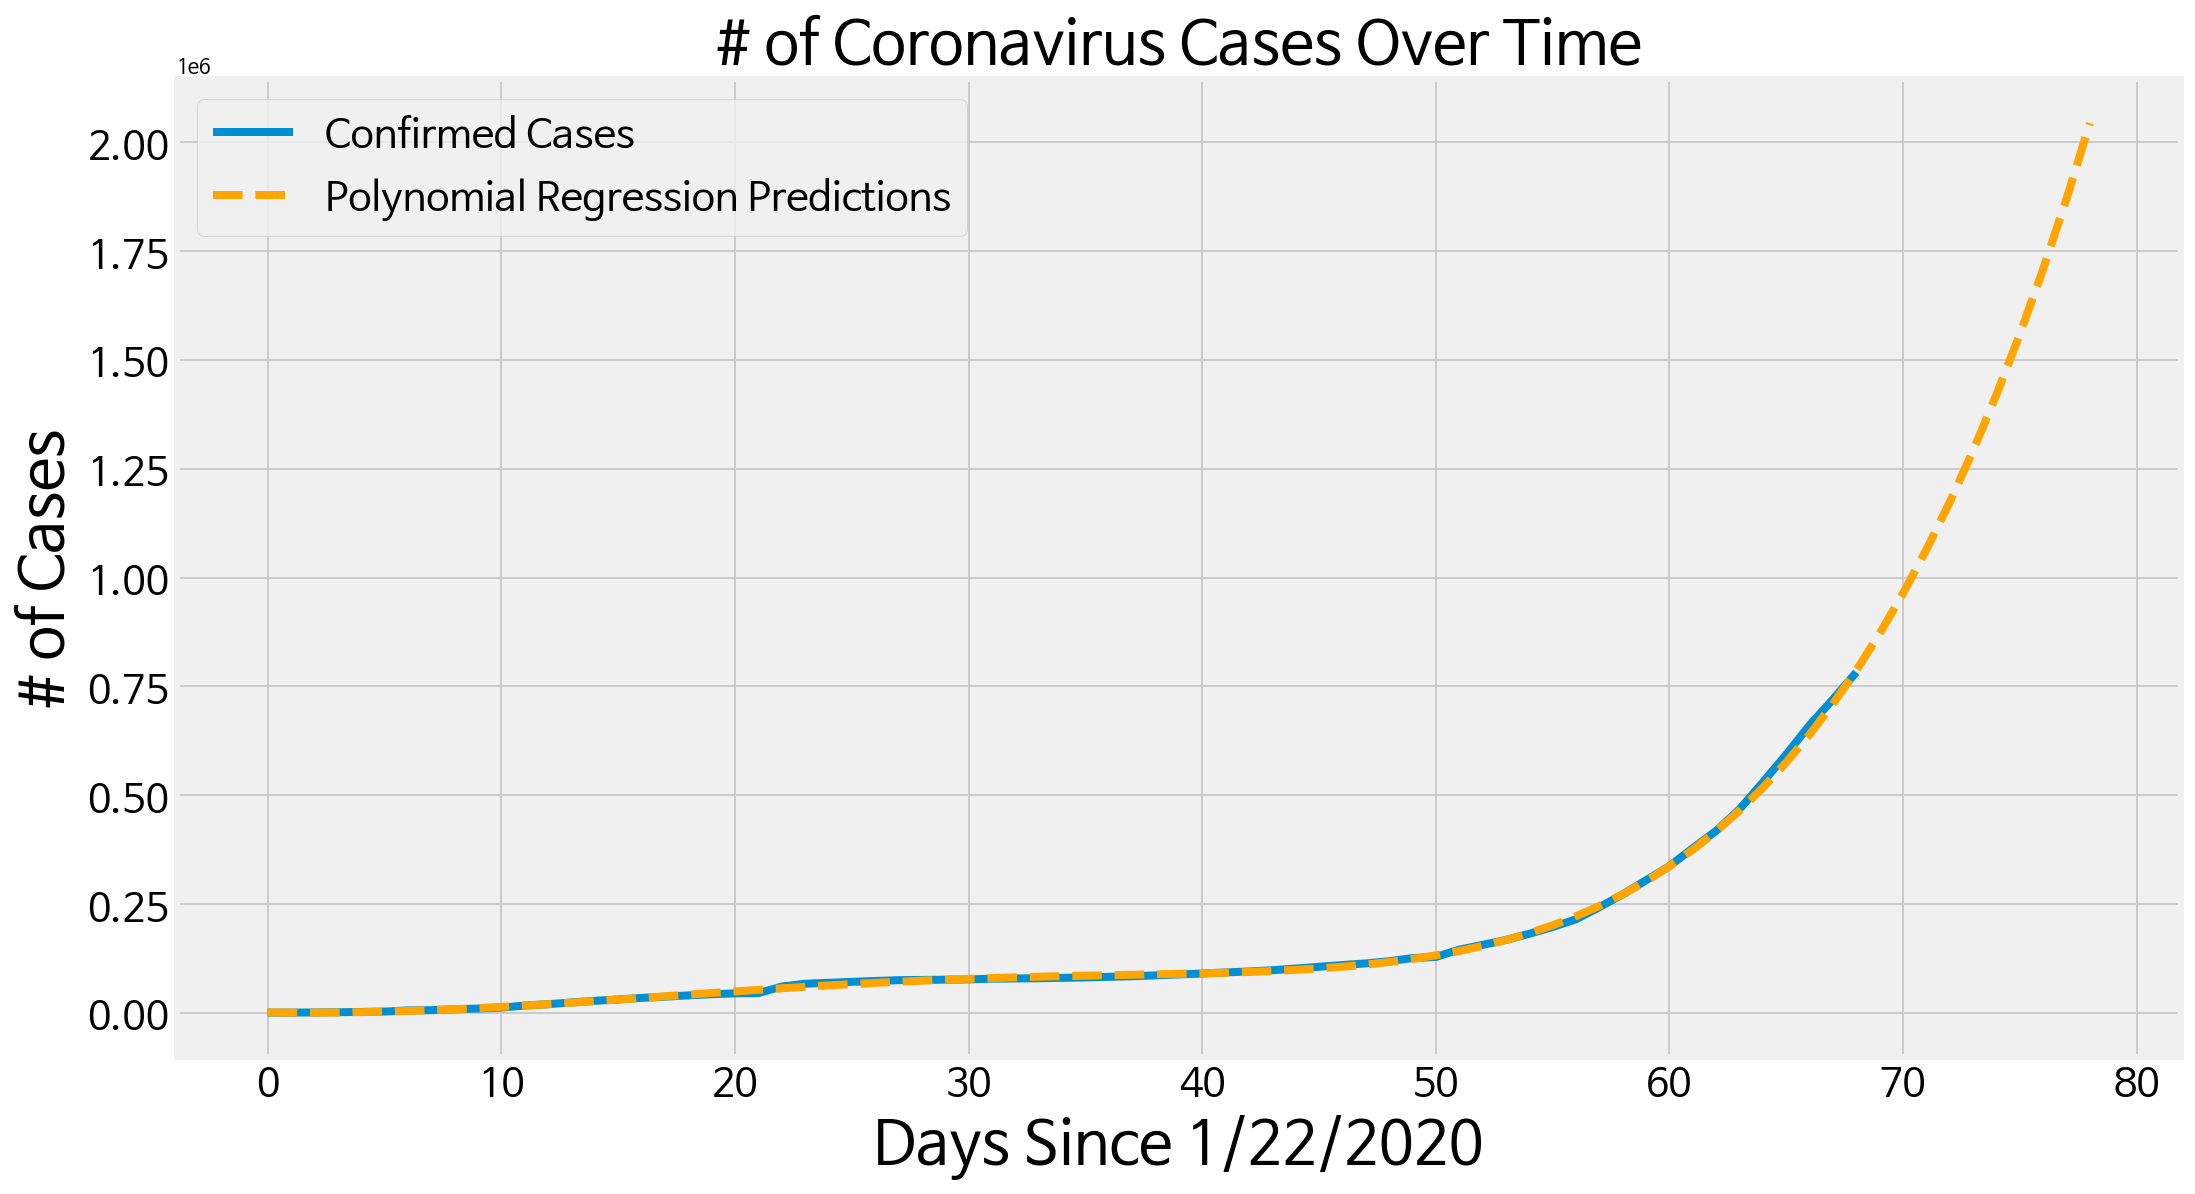

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, linear_pred, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Polynomial Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

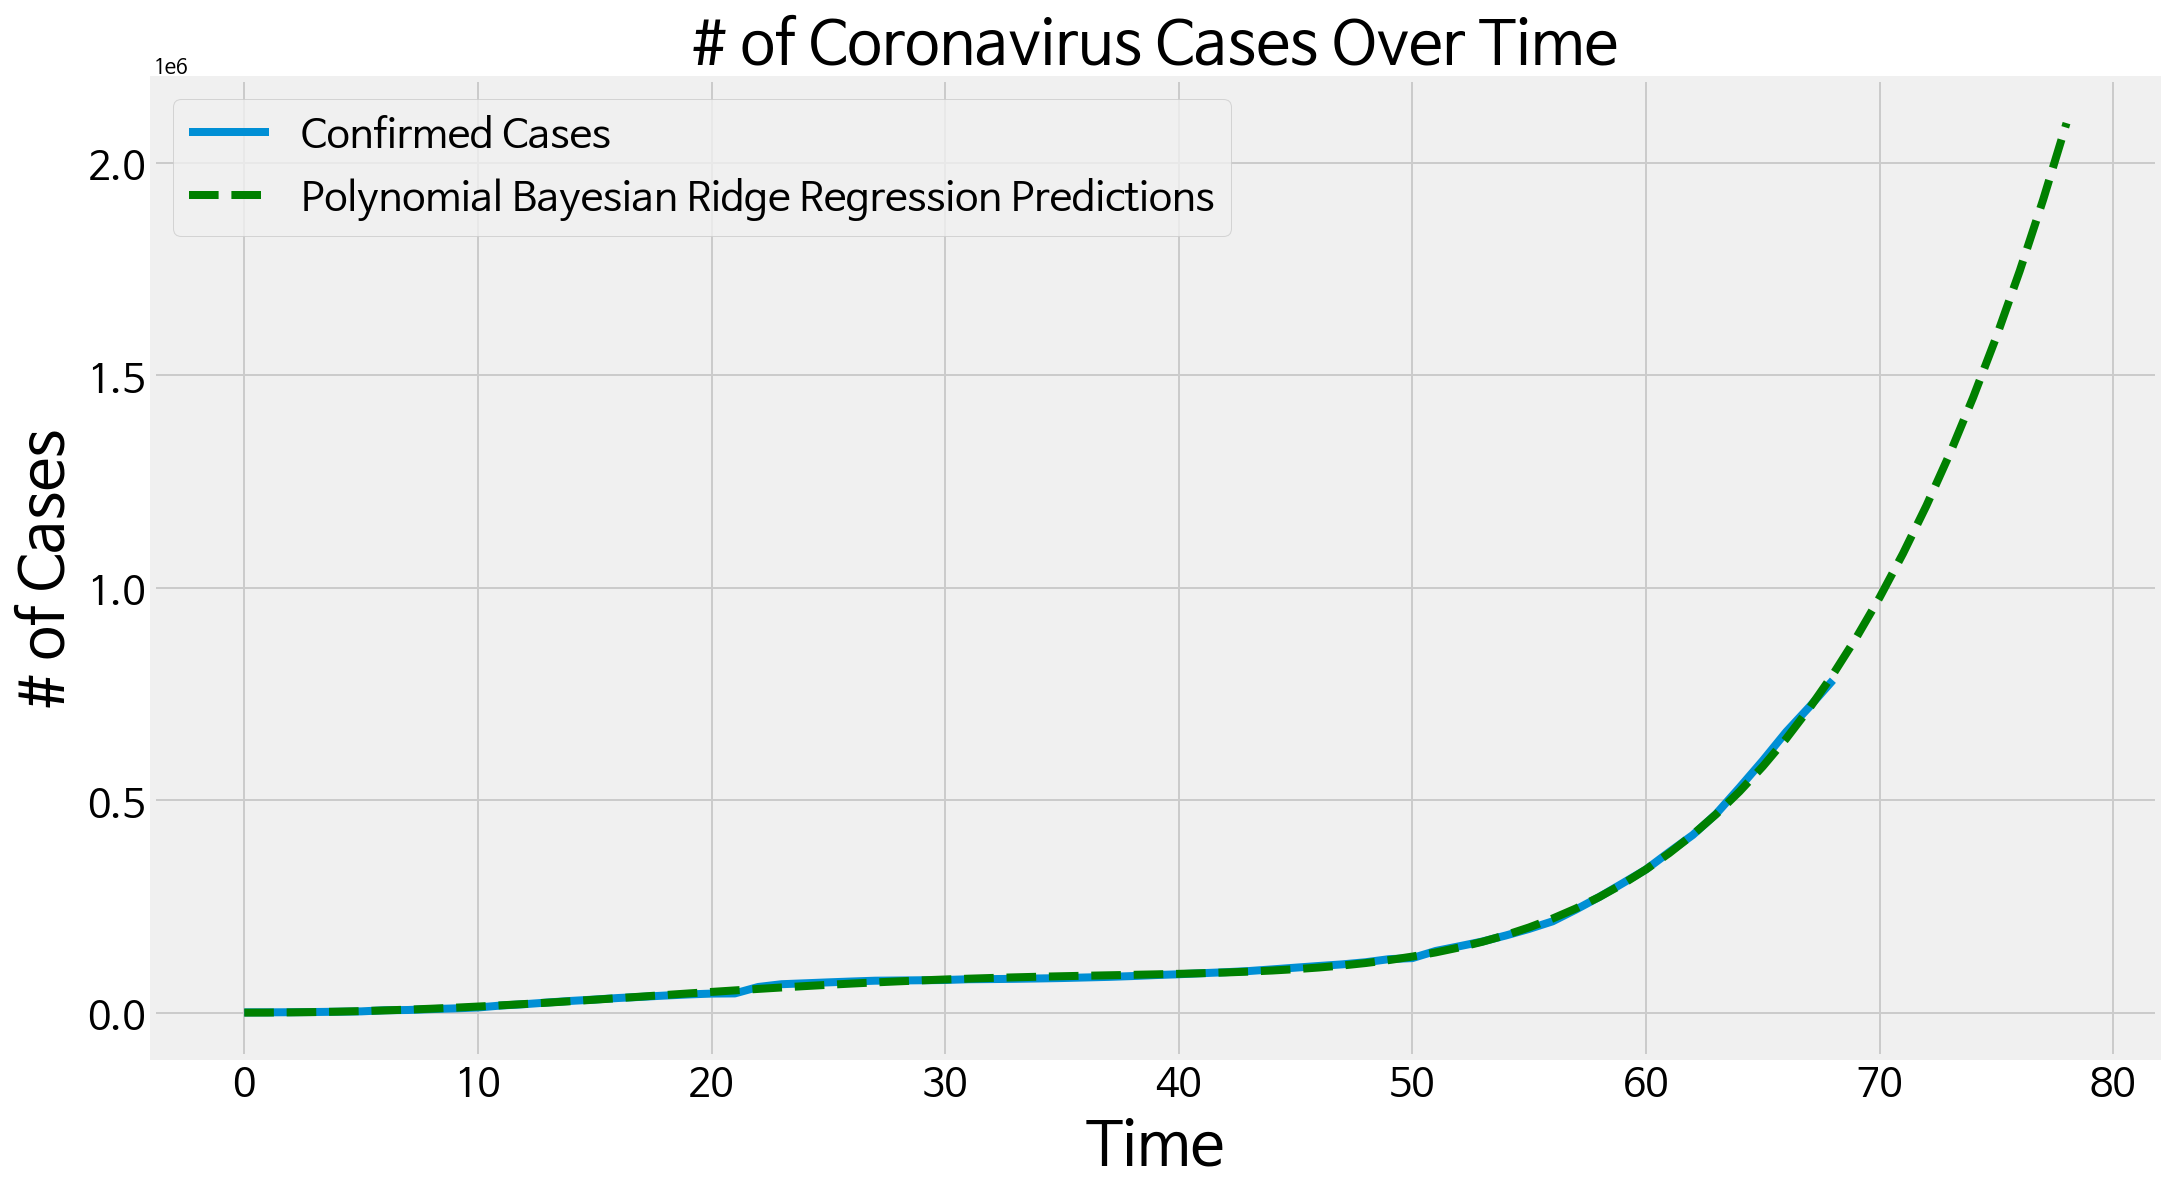

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, bayesian_pred, linestyle='dashed', color='green')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Polynomial Bayesian Ridge Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
# Future predictions using SVM 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-10:])})
svm_df

,Date,SVM Predicted # of Confirmed Cases Worldwide
0,03/31/2020,798955.0
1,04/01/2020,877715.0
2,04/02/2020,963523.0
3,04/03/2020,1056897.0
4,04/04/2020,1158386.0
5,04/05/2020,1268568.0
6,04/06/2020,1388055.0
7,04/07/2020,1517493.0
8,04/08/2020,1657563.0
9,04/09/2020,1808984.0


In [ ]:
# Future predictions using polynomial regression
linear_pred = linear_pred.reshape(1,-1)[0]
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases Worldwide': np.round(linear_pred[-10:])})
svm_df

,Date,Polynomial Predicted # of Confirmed Cases Worldwide
0,03/31/2020,871204.0
1,04/01/2020,963405.0
2,04/02/2020,1063855.0
3,04/03/2020,1173070.0
4,04/04/2020,1291587.0
5,04/05/2020,1419962.0
6,04/06/2020,1558773.0
7,04/07/2020,1708619.0
8,04/08/2020,1870118.0
9,04/09/2020,2043911.0


In [ ]:
# Future predictions using Bayesian Ridge 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Bayesian Ridge Predicted # of Confirmed Cases Worldwide': np.round(bayesian_pred[-10:])})
svm_df

,Date,Bayesian Ridge Predicted # of Confirmed Cases Worldwide
0,03/31/2020,882480.0
1,04/01/2020,977179.0
2,04/02/2020,1080490.0
3,04/03/2020,1192964.0
4,04/04/2020,1315173.0
5,04/05/2020,1447711.0
6,04/06/2020,1591196.0
7,04/07/2020,1746269.0
8,04/08/2020,1913591.0
9,04/09/2020,2093850.0


### Real Metropolitan Cases (confirmed - released - deceased)

In [ ]:
# 도시 각각의 프레임을 배열로 저장
province_data = []
for province in provinces:
    province_data.append(del_data[del_data.province == province])

# 실제 확진자 수 구하기 (confirmed - released - deceased)
for i in range(len(provinces)):
    province_data[i]['real_confirmed'] = province_data[i]['confirmed'] - province_data[i]['released'] - province_data[i]['deceased']
real_province_data = province_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
real_province_data[0].loc['2020-03-25']
real_province_data[0]

,province,confirmed,released,deceased,real_confirmed
date,,,,,
2020-01-20,Gyeongsangbuk-do,0,0,0,0
2020-01-21,Gyeongsangbuk-do,0,0,0,0
2020-01-22,Gyeongsangbuk-do,0,0,0,0
2020-01-23,Gyeongsangbuk-do,0,0,0,0
2020-01-24,Gyeongsangbuk-do,0,0,0,0
...,...,...,...,...,...
2020-03-26,Gyeongsangbuk-do,1274,601,30,643
2020-03-27,Gyeongsangbuk-do,1283,650,34,599
2020-03-28,Gyeongsangbuk-do,1285,692,35,558


In [ ]:
# column name : real_confirmed -> city name
real_metropolitan_data = []
for i in range(len(provinces)):
    real_metropolitan_data.append(real_province_data[i].drop(columns=['province', 'confirmed', 'released', 'deceased'], inplace=False))
    real_metropolitan_data[i].columns = [provinces[i]]
real_metropolitan_data

# # 도시별 데이터 프레임을 하나의 데이터 프레임으로 합친다
# province_data = province_data[0].join(province_data[1:])
# province_data

# # 수도권 확진자 데이터
# metropolitan_data = pd.DataFrame({'Seoul':province_data['Seoul'], 'Incheon':province_data['Incheon'], 'Gyeonggi-do':province_data['Gyeonggi-do']})
# metropolitan_data

[            Gyeongsangbuk-do
 date                        
 2020-01-20                 0
 2020-01-21                 0
 2020-01-22                 0
 2020-01-23                 0
 2020-01-24                 0
 ...                      ...
 2020-03-26               643
 2020-03-27               599
 2020-03-28               558
 2020-03-29               518
 2020-03-30               488
 
 [71 rows x 1 columns],             Seoul
 date             
 2020-01-20      0
 2020-01-21      0
 2020-01-22      0
 2020-01-23      0
 2020-01-24      0
 ...           ...
 2020-03-26    280
 2020-03-27    283
 2020-03-28    297
 2020-03-29    317
 2020-03-30    334
 
 [71 rows x 1 columns],             Gyeonggi-do
 date                   
 2020-01-20            0
 2020-01-21            0
 2020-01-22            0
 2020-01-23            0
 2020-01-24            1
 ...                 ...
 2020-03-26          275
 2020-03-27          277
 2020-03-28          288
 2020-03-29          299
 2020-03-30  

In [ ]:
# 수도권의 확진자 합계
real_metropolitan_data = real_metropolitan_data.sum(axis=1)
real_metropolitan_data = pd.DataFrame({'metropolitan':real_metropolitan_data})
real_metropolitan_data

AttributeError: ignored

In [ ]:
# 1/20 부터 시작하는 데이터 1/22로 변경
real_metropolitan_data = real_metropolitan_data[2:]

# 수도권 확진자 데이터 리스트 형식, daily_increase 함수에 넣기위해 다른 cases 변수와 형태를 같이함
real_metropolitan_cases = list(real_metropolitan_data['metropolitan'])

# 하루 확진자 증가량
real_metropolitan_daily_increase = daily_increase(real_metropolitan_cases)

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, np.log10(real_metropolitan_cases))
plt.title('Log of # of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(future_forcast_dates[:69], np.log10(china_cases[:69]))
plt.plot(future_forcast_dates[:69], np.log10(italy_cases[:69]))
plt.plot(future_forcast_dates[:69], np.log10(us_cases[:69]))
plt.plot(future_forcast_dates[:69], np.log10(spain_cases[:69]))
# plt.plot(future_forcast_dates[:69], np.log10(france_cases[:69]))
plt.plot(future_forcast_dates[:69], np.log10(korea_cases[:69]))
plt.plot(future_forcast_dates[:69], np.log10(metropolitan_cases[:69]))
plt.plot(future_forcast_dates[:69], np.log10(real_metropolitan_cases[:69]))

plt.title('전세계 코로나 바이러스 누적 확진자 로그 스케일', size=30)
# plt.xlabel('1/22 ~ 3/30', size=30)
# plt.ylabel('확진자', size=30)
plt.legend(['China', 'Italy', 'US', 'Spain', 'Korea', 'Metropolitan(서울, 인천, 경기)', 'Real(확진-완치-사망) Metro'], prop={'size': 20})
plt.xticks(date_tick, size=20, rotation=45)
plt.yticks(size=20)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(future_forcast_dates[:69], metropolitan_cases[:69])
plt.title('수도권 코로나 바이러스 누적 확진자', size=30)
# plt.xlabel('1/22 ~ 3/30', size=30)
# plt.ylabel('확진자', size=30)
# plt.legend(['Korea'], prop={'size': 20})
plt.xticks(date_tick, size=20, rotation=45)
plt.yticks(size=20)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(future_forcast_dates[:69], real_metropolitan_cases[:69])
plt.title('수도권 코로나 바이러스 실제 확진자(확진-완치-사망)', size=30)
# plt.xlabel('1/22 ~ 3/30', size=30)
# plt.ylabel('확진자', size=30)
# plt.legend(['Korea'], prop={'size': 20})
plt.xticks(date_tick, size=20, rotation=45)
plt.yticks(size=20)
plt.show()

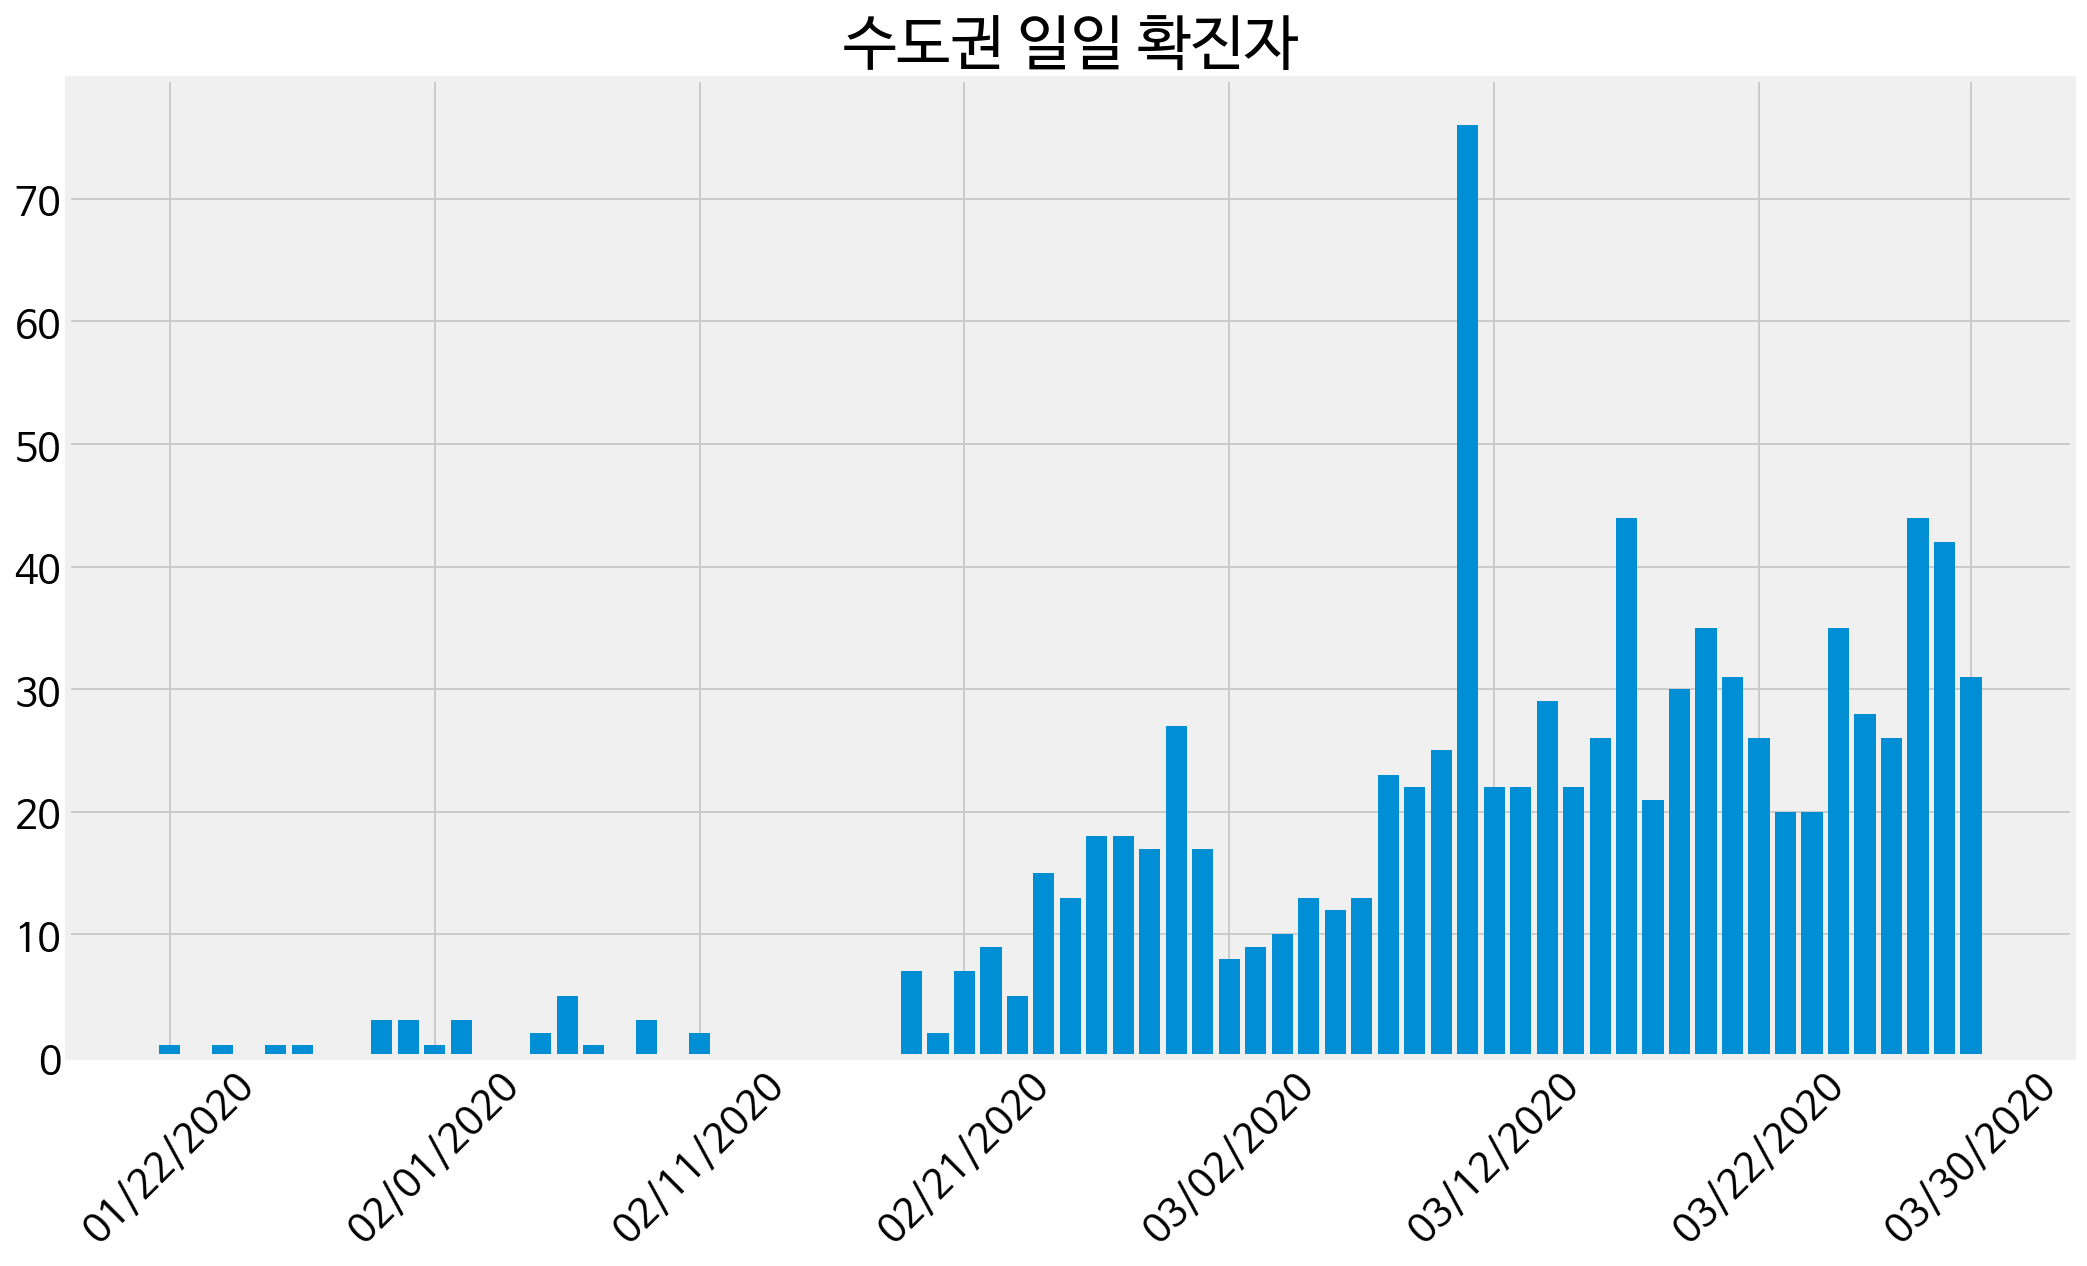

In [ ]:
plt.figure(figsize=(16, 9))
plt.bar(future_forcast_dates[:69], metropolitan_daily_increase[:69])
plt.title('수도권 일일 확진자', size=30)
# plt.xlabel('Days Since 1/22/2020', size=30)
# plt.ylabel('확진자', size=30)
plt.xticks(date_tick, size=20, rotation=45)
plt.yticks(size=20)
plt.show()

In [ ]:
print(real_metropolitan_daily_increase[62])
future_forcast_dates[62]
# print(metropolitan_daily_increase[66])
# len(metropolitan_daily_increase)
real_metropolitan_data

In [ ]:
plt.figure(figsize=(16, 9))
plt.bar(future_forcast_dates[:66], real_metropolitan_daily_increase[:66])
plt.title('수도권 실제 일일 확진자(확진-완치-사망)', size=30)
# plt.xlabel('Days Since 1/22/2020', size=30)
# plt.ylabel('# of Cases', size=30)
plt.xticks(date_tick, size=20, rotation=45)
plt.yticks(size=20)
plt.show()

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(future_forcast_dates[:69], np.log10(metropolitan_daily_increase[:69]))
plt.title('Log of # of Coronavirus Cases Over Time', size=30)
# plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('확진자', size=30)
plt.xticks(date_tick, size=20, rotation=45)
plt.yticks(size=20)
plt.show()

### Pie Province Graph

In [ ]:
# 시간 컬럼 삭제 후 인덱스를 시간으로 변경
del_data = data.drop(columns=['time'])
del_data.set_index('date', inplace=True)

# 도시 목록
provinces = list(set(del_data.province.tolist()))
provinces

# 도시 각각의 프레임을 배열로 저장
pie_province_data = []
for province in provinces:
    pie_province_data.append(del_data[del_data.province == province])

# 도시, 완치, 사망 컬럼 삭제 후 province 컬럼의 이름을 실제 도시 이름으로 변경
for i in range(len(provinces)):
    pie_province_data[i].drop(columns=['province', 'released', 'deceased'], inplace=True)
    pie_province_data[i].columns = [provinces[i]]
    
# 도시별 데이터 프레임을 하나의 데이터 프레임으로 합친다
pie_province_data = pie_province_data[0].join(pie_province_data[1:])
pie_province_data

In [ ]:
pie_province_data_03_30 = pie_province_data.loc['2020-03-30']
t_daegu = pie_province_data_03_30['Daegu']
t_gyeongsangbuk_do = pie_province_data_03_30['Gyeongsangbuk-do']
t_sum_other = sum(pie_province_data_03_30) - t_daegu - t_gyeongsangbuk_do
t_sum_other

In [ ]:
pie_data = [t_daegu, t_gyeongsangbuk_do, t_sum_other]

In [ ]:
# import random
# import matplotlib.colors as mcolors

# c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(provinces))
plt.figure(figsize=(16,8))
plt.title('도시별 확진자 비율', size=20)
plt.pie(pie_data, autopct='%0.1f%%', textprops={'fontsize': 16})
# plt.pie(pie_province_data_03_30, colors=c, autopct='%0.1f%%', textprops={'fontsize': 16})
# plt.legend(provinces, loc='best', fontsize=15)
plt.legend(['Daegu', 'Gyeongsangbuk-do', 'Other'], loc='best', fontsize=15)

plt.show()